In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1934360, 828)
(1934360, 8)
validation
(228776, 828)
(228776, 8)
test
(289081, 828)
(289081, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/194 [..............................] - ETA: 5:16 - loss: 2.2517 - STD: 0.0689 - MAE: 0.2197

  4/194 [..............................] - ETA: 4s - loss: 2.1187 - STD: 0.0491 - MAE: 0.2173  

  7/194 [>.............................] - ETA: 4s - loss: 2.1090 - STD: 0.0523 - MAE: 0.2166

 10/194 [>.............................] - ETA: 4s - loss: 2.0951 - STD: 0.0482 - MAE: 0.2166

 13/194 [=>............................] - ETA: 4s - loss: 2.0858 - STD: 0.0443 - MAE: 0.2166

 16/194 [=>............................] - ETA: 4s - loss: 2.0801 - STD: 0.0417 - MAE: 0.2167

 19/194 [=>............................] - ETA: 4s - loss: 2.0750 - STD: 0.0403 - MAE: 0.2167

 22/194 [==>...........................] - ETA: 3s - loss: 2.0700 - STD: 0.0395 - MAE: 0.2166

 25/194 [==>...........................] - ETA: 3s - loss: 2.0655 - STD: 0.0388 - MAE: 0.2165

 28/194 [===>..........................] - ETA: 3s - loss: 2.0599 - STD: 0.0385 - MAE: 0.2163

 31/194 [===>..........................] - ETA: 3s - loss: 2.0532 - STD: 0.0387 - MAE: 0.2161

 34/194 [====>.........................] - ETA: 3s - loss: 2.0453 - STD: 0.0394 - MAE: 0.2158

 37/194 [====>.........................] - ETA: 3s - loss: 2.0370 - STD: 0.0406 - MAE: 0.2154

 40/194 [=====>........................] - ETA: 3s - loss: 2.0275 - STD: 0.0418 - MAE: 0.2150

 43/194 [=====>........................] - ETA: 3s - loss: 2.0173 - STD: 0.0434 - MAE: 0.2145

 46/194 [======>.......................] - ETA: 3s - loss: 2.0065 - STD: 0.0451 - MAE: 0.2139

 49/194 [======>.......................] - ETA: 3s - loss: 1.9954 - STD: 0.0469 - MAE: 0.2134

 52/194 [=======>......................] - ETA: 3s - loss: 1.9842 - STD: 0.0488 - MAE: 0.2128

 55/194 [=======>......................] - ETA: 3s - loss: 1.9723 - STD: 0.0507 - MAE: 0.2122

 58/194 [=======>......................] - ETA: 3s - loss: 1.9598 - STD: 0.0527 - MAE: 0.2115

 61/194 [========>.....................] - ETA: 3s - loss: 1.9470 - STD: 0.0547 - MAE: 0.2108

 64/194 [========>.....................] - ETA: 2s - loss: 1.9332 - STD: 0.0567 - MAE: 0.2101

 67/194 [=========>....................] - ETA: 2s - loss: 1.9187 - STD: 0.0587 - MAE: 0.2093

 70/194 [=========>....................] - ETA: 2s - loss: 1.9038 - STD: 0.0609 - MAE: 0.2085

 73/194 [==========>...................] - ETA: 2s - loss: 1.8890 - STD: 0.0630 - MAE: 0.2076

 76/194 [==========>...................] - ETA: 2s - loss: 1.8738 - STD: 0.0652 - MAE: 0.2067

 79/194 [===========>..................] - ETA: 2s - loss: 1.8589 - STD: 0.0674 - MAE: 0.2058

 82/194 [===========>..................] - ETA: 2s - loss: 1.8447 - STD: 0.0697 - MAE: 0.2050

 85/194 [============>.................] - ETA: 2s - loss: 1.8309 - STD: 0.0719 - MAE: 0.2041

 88/194 [============>.................] - ETA: 2s - loss: 1.8178 - STD: 0.0740 - MAE: 0.2032

 91/194 [=============>................] - ETA: 2s - loss: 1.8052 - STD: 0.0761 - MAE: 0.2024

 94/194 [=============>................] - ETA: 2s - loss: 1.7927 - STD: 0.0780 - MAE: 0.2015

 97/194 [==============>...............] - ETA: 2s - loss: 1.7808 - STD: 0.0800 - MAE: 0.2007

100/194 [==============>...............] - ETA: 2s - loss: 1.7714 - STD: 0.0819 - MAE: 0.1999

103/194 [==============>...............] - ETA: 2s - loss: 1.7605 - STD: 0.0836 - MAE: 0.1992

106/194 [===============>..............] - ETA: 2s - loss: 1.7497 - STD: 0.0853 - MAE: 0.1985

109/194 [===============>..............] - ETA: 2s - loss: 1.7392 - STD: 0.0871 - MAE: 0.1977

112/194 [================>.............] - ETA: 2s - loss: 1.7292 - STD: 0.0887 - MAE: 0.1970

115/194 [================>.............] - ETA: 2s - loss: 1.7197 - STD: 0.0903 - MAE: 0.1963

118/194 [=================>............] - ETA: 2s - loss: 1.7104 - STD: 0.0919 - MAE: 0.1957

121/194 [=================>............] - ETA: 2s - loss: 1.7015 - STD: 0.0934 - MAE: 0.1950

124/194 [==================>...........] - ETA: 2s - loss: 1.6927 - STD: 0.0948 - MAE: 0.1944

127/194 [==================>...........] - ETA: 1s - loss: 1.6842 - STD: 0.0962 - MAE: 0.1937

130/194 [===================>..........] - ETA: 1s - loss: 1.6760 - STD: 0.0976 - MAE: 0.1931

133/194 [===================>..........] - ETA: 1s - loss: 1.6682 - STD: 0.0989 - MAE: 0.1925

136/194 [====================>.........] - ETA: 1s - loss: 1.6606 - STD: 0.1002 - MAE: 0.1920

139/194 [====================>.........] - ETA: 1s - loss: 1.6535 - STD: 0.1014 - MAE: 0.1914

142/194 [====================>.........] - ETA: 1s - loss: 1.6464 - STD: 0.1026 - MAE: 0.1909

145/194 [=====================>........] - ETA: 1s - loss: 1.6394 - STD: 0.1038 - MAE: 0.1903

148/194 [=====================>........] - ETA: 1s - loss: 1.6327 - STD: 0.1050 - MAE: 0.1898

151/194 [======================>.......] - ETA: 1s - loss: 1.6263 - STD: 0.1061 - MAE: 0.1893

154/194 [======================>.......] - ETA: 1s - loss: 1.6199 - STD: 0.1072 - MAE: 0.1888

157/194 [=======================>......] - ETA: 1s - loss: 1.6138 - STD: 0.1082 - MAE: 0.1884

160/194 [=======================>......] - ETA: 0s - loss: 1.6076 - STD: 0.1093 - MAE: 0.1879

163/194 [========================>.....] - ETA: 0s - loss: 1.6016 - STD: 0.1103 - MAE: 0.1874

166/194 [========================>.....] - ETA: 0s - loss: 1.5957 - STD: 0.1112 - MAE: 0.1869

169/194 [=========================>....] - ETA: 0s - loss: 1.5899 - STD: 0.1122 - MAE: 0.1865

172/194 [=========================>....] - ETA: 0s - loss: 1.5843 - STD: 0.1132 - MAE: 0.1860

175/194 [==========================>...] - ETA: 0s - loss: 1.5786 - STD: 0.1141 - MAE: 0.1856

178/194 [==========================>...] - ETA: 0s - loss: 1.5732 - STD: 0.1150 - MAE: 0.1851

181/194 [==========================>...] - ETA: 0s - loss: 1.5681 - STD: 0.1159 - MAE: 0.1847

184/194 [===========================>..] - ETA: 0s - loss: 1.5630 - STD: 0.1167 - MAE: 0.1843

187/194 [===========================>..] - ETA: 0s - loss: 1.5580 - STD: 0.1176 - MAE: 0.1839

190/194 [============================>.] - ETA: 0s - loss: 1.5532 - STD: 0.1184 - MAE: 0.1835

193/194 [============================>.] - ETA: 0s - loss: 1.5484 - STD: 0.1192 - MAE: 0.1831

194/194 [==============================] - 8s 33ms/step - loss: 1.5469 - STD: 0.1195 - MAE: 0.1830 - val_loss: 1.3566 - val_STD: 0.1718 - val_MAE: 0.1607


Epoch 2/10000


  1/194 [..............................] - ETA: 10s - loss: 1.2427 - STD: 0.1736 - MAE: 0.1568

  4/194 [..............................] - ETA: 4s - loss: 1.2399 - STD: 0.1724 - MAE: 0.1572 

  7/194 [>.............................] - ETA: 3s - loss: 1.2329 - STD: 0.1722 - MAE: 0.1569

 10/194 [>.............................] - ETA: 3s - loss: 1.2343 - STD: 0.1723 - MAE: 0.1570

 13/194 [=>............................] - ETA: 3s - loss: 1.2327 - STD: 0.1726 - MAE: 0.1569

 16/194 [=>............................] - ETA: 3s - loss: 1.2316 - STD: 0.1729 - MAE: 0.1567

 19/194 [=>............................] - ETA: 3s - loss: 1.2316 - STD: 0.1731 - MAE: 0.1566

 22/194 [==>...........................] - ETA: 3s - loss: 1.2305 - STD: 0.1732 - MAE: 0.1565

 25/194 [==>...........................] - ETA: 3s - loss: 1.2277 - STD: 0.1734 - MAE: 0.1563

 28/194 [===>..........................] - ETA: 3s - loss: 1.2263 - STD: 0.1736 - MAE: 0.1562

 31/194 [===>..........................] - ETA: 3s - loss: 1.2245 - STD: 0.1738 - MAE: 0.1560

 34/194 [====>.........................] - ETA: 3s - loss: 1.2229 - STD: 0.1741 - MAE: 0.1558

 37/194 [====>.........................] - ETA: 3s - loss: 1.2218 - STD: 0.1744 - MAE: 0.1556

 40/194 [=====>........................] - ETA: 3s - loss: 1.2200 - STD: 0.1747 - MAE: 0.1554

 43/194 [=====>........................] - ETA: 3s - loss: 1.2183 - STD: 0.1749 - MAE: 0.1553

 46/194 [======>.......................] - ETA: 3s - loss: 1.2168 - STD: 0.1751 - MAE: 0.1551

 49/194 [======>.......................] - ETA: 3s - loss: 1.2151 - STD: 0.1753 - MAE: 0.1550

 52/194 [=======>......................] - ETA: 3s - loss: 1.2134 - STD: 0.1755 - MAE: 0.1548

 55/194 [=======>......................] - ETA: 3s - loss: 1.2123 - STD: 0.1757 - MAE: 0.1547

 58/194 [=======>......................] - ETA: 3s - loss: 1.2117 - STD: 0.1759 - MAE: 0.1546

 61/194 [========>.....................] - ETA: 2s - loss: 1.2109 - STD: 0.1762 - MAE: 0.1545

 64/194 [========>.....................] - ETA: 2s - loss: 1.2097 - STD: 0.1764 - MAE: 0.1543

 67/194 [=========>....................] - ETA: 2s - loss: 1.2088 - STD: 0.1766 - MAE: 0.1542

 70/194 [=========>....................] - ETA: 2s - loss: 1.2077 - STD: 0.1767 - MAE: 0.1541

 73/194 [==========>...................] - ETA: 2s - loss: 1.2067 - STD: 0.1769 - MAE: 0.1540

 76/194 [==========>...................] - ETA: 2s - loss: 1.2058 - STD: 0.1770 - MAE: 0.1539

 79/194 [===========>..................] - ETA: 2s - loss: 1.2046 - STD: 0.1772 - MAE: 0.1538

 82/194 [===========>..................] - ETA: 2s - loss: 1.2035 - STD: 0.1774 - MAE: 0.1537

 85/194 [============>.................] - ETA: 2s - loss: 1.2024 - STD: 0.1776 - MAE: 0.1535

 88/194 [============>.................] - ETA: 2s - loss: 1.2010 - STD: 0.1778 - MAE: 0.1534

 91/194 [=============>................] - ETA: 2s - loss: 1.1997 - STD: 0.1779 - MAE: 0.1533

 94/194 [=============>................] - ETA: 2s - loss: 1.1984 - STD: 0.1781 - MAE: 0.1531

 97/194 [==============>...............] - ETA: 2s - loss: 1.1973 - STD: 0.1783 - MAE: 0.1530

100/194 [==============>...............] - ETA: 2s - loss: 1.1957 - STD: 0.1785 - MAE: 0.1529

103/194 [==============>...............] - ETA: 2s - loss: 1.1943 - STD: 0.1786 - MAE: 0.1528

106/194 [===============>..............] - ETA: 1s - loss: 1.1926 - STD: 0.1789 - MAE: 0.1526

109/194 [===============>..............] - ETA: 1s - loss: 1.1913 - STD: 0.1791 - MAE: 0.1524

112/194 [================>.............] - ETA: 1s - loss: 1.1899 - STD: 0.1792 - MAE: 0.1523

115/194 [================>.............] - ETA: 1s - loss: 1.1885 - STD: 0.1794 - MAE: 0.1522

118/194 [=================>............] - ETA: 1s - loss: 1.1877 - STD: 0.1796 - MAE: 0.1521

121/194 [=================>............] - ETA: 1s - loss: 1.1862 - STD: 0.1798 - MAE: 0.1519

124/194 [==================>...........] - ETA: 1s - loss: 1.1847 - STD: 0.1799 - MAE: 0.1518

127/194 [==================>...........] - ETA: 1s - loss: 1.1840 - STD: 0.1802 - MAE: 0.1517

130/194 [===================>..........] - ETA: 1s - loss: 1.1842 - STD: 0.1803 - MAE: 0.1516

133/194 [===================>..........] - ETA: 1s - loss: 1.1841 - STD: 0.1805 - MAE: 0.1515

136/194 [====================>.........] - ETA: 1s - loss: 1.1834 - STD: 0.1806 - MAE: 0.1515

139/194 [====================>.........] - ETA: 1s - loss: 1.1823 - STD: 0.1808 - MAE: 0.1514

142/194 [====================>.........] - ETA: 1s - loss: 1.1813 - STD: 0.1809 - MAE: 0.1513

145/194 [=====================>........] - ETA: 1s - loss: 1.1803 - STD: 0.1810 - MAE: 0.1512

148/194 [=====================>........] - ETA: 1s - loss: 1.1792 - STD: 0.1812 - MAE: 0.1510

151/194 [======================>.......] - ETA: 0s - loss: 1.1778 - STD: 0.1813 - MAE: 0.1509

154/194 [======================>.......] - ETA: 0s - loss: 1.1767 - STD: 0.1815 - MAE: 0.1508

157/194 [=======================>......] - ETA: 0s - loss: 1.1755 - STD: 0.1816 - MAE: 0.1507

160/194 [=======================>......] - ETA: 0s - loss: 1.1741 - STD: 0.1818 - MAE: 0.1506

163/194 [========================>.....] - ETA: 0s - loss: 1.1729 - STD: 0.1819 - MAE: 0.1505

166/194 [========================>.....] - ETA: 0s - loss: 1.1715 - STD: 0.1820 - MAE: 0.1503

169/194 [=========================>....] - ETA: 0s - loss: 1.1704 - STD: 0.1822 - MAE: 0.1502

172/194 [=========================>....] - ETA: 0s - loss: 1.1693 - STD: 0.1823 - MAE: 0.1501

175/194 [==========================>...] - ETA: 0s - loss: 1.1683 - STD: 0.1825 - MAE: 0.1500

178/194 [==========================>...] - ETA: 0s - loss: 1.1670 - STD: 0.1826 - MAE: 0.1499

181/194 [==========================>...] - ETA: 0s - loss: 1.1658 - STD: 0.1828 - MAE: 0.1498

184/194 [===========================>..] - ETA: 0s - loss: 1.1648 - STD: 0.1829 - MAE: 0.1496

187/194 [===========================>..] - ETA: 0s - loss: 1.1638 - STD: 0.1831 - MAE: 0.1495

190/194 [============================>.] - ETA: 0s - loss: 1.1625 - STD: 0.1832 - MAE: 0.1494

193/194 [============================>.] - ETA: 0s - loss: 1.1613 - STD: 0.1834 - MAE: 0.1493

194/194 [==============================] - 5s 25ms/step - loss: 1.1611 - STD: 0.1834 - MAE: 0.1493 - val_loss: 1.2980 - val_STD: 0.1921 - val_MAE: 0.1495


Epoch 3/10000


  1/194 [..............................] - ETA: 10s - loss: 1.1158 - STD: 0.1923 - MAE: 0.1433

  4/194 [..............................] - ETA: 4s - loss: 1.0954 - STD: 0.1927 - MAE: 0.1421 

  7/194 [>.............................] - ETA: 4s - loss: 1.0915 - STD: 0.1927 - MAE: 0.1420

 10/194 [>.............................] - ETA: 4s - loss: 1.0892 - STD: 0.1927 - MAE: 0.1419

 13/194 [=>............................] - ETA: 4s - loss: 1.0906 - STD: 0.1927 - MAE: 0.1420

 16/194 [=>............................] - ETA: 4s - loss: 1.0899 - STD: 0.1929 - MAE: 0.1419

 19/194 [=>............................] - ETA: 4s - loss: 1.0902 - STD: 0.1932 - MAE: 0.1418

 22/194 [==>...........................] - ETA: 3s - loss: 1.0936 - STD: 0.1935 - MAE: 0.1419

 25/194 [==>...........................] - ETA: 3s - loss: 1.0950 - STD: 0.1936 - MAE: 0.1419

 28/194 [===>..........................] - ETA: 3s - loss: 1.0936 - STD: 0.1936 - MAE: 0.1418

 31/194 [===>..........................] - ETA: 3s - loss: 1.0914 - STD: 0.1939 - MAE: 0.1417

 34/194 [====>.........................] - ETA: 3s - loss: 1.0898 - STD: 0.1939 - MAE: 0.1415

 37/194 [====>.........................] - ETA: 3s - loss: 1.0896 - STD: 0.1940 - MAE: 0.1415

 40/194 [=====>........................] - ETA: 3s - loss: 1.0880 - STD: 0.1941 - MAE: 0.1414

 43/194 [=====>........................] - ETA: 3s - loss: 1.0867 - STD: 0.1942 - MAE: 0.1413

 46/194 [======>.......................] - ETA: 3s - loss: 1.0851 - STD: 0.1943 - MAE: 0.1411

 49/194 [======>.......................] - ETA: 3s - loss: 1.0840 - STD: 0.1945 - MAE: 0.1410

 52/194 [=======>......................] - ETA: 3s - loss: 1.0823 - STD: 0.1946 - MAE: 0.1408

 55/194 [=======>......................] - ETA: 3s - loss: 1.0817 - STD: 0.1947 - MAE: 0.1408

 58/194 [=======>......................] - ETA: 3s - loss: 1.0802 - STD: 0.1949 - MAE: 0.1406

 61/194 [========>.....................] - ETA: 3s - loss: 1.0794 - STD: 0.1951 - MAE: 0.1405

 64/194 [========>.....................] - ETA: 2s - loss: 1.0779 - STD: 0.1952 - MAE: 0.1404

 67/194 [=========>....................] - ETA: 2s - loss: 1.0768 - STD: 0.1953 - MAE: 0.1403

 70/194 [=========>....................] - ETA: 2s - loss: 1.0755 - STD: 0.1954 - MAE: 0.1402

 73/194 [==========>...................] - ETA: 2s - loss: 1.0748 - STD: 0.1955 - MAE: 0.1401

 76/194 [==========>...................] - ETA: 2s - loss: 1.0733 - STD: 0.1956 - MAE: 0.1399

 79/194 [===========>..................] - ETA: 2s - loss: 1.0730 - STD: 0.1958 - MAE: 0.1399

 82/194 [===========>..................] - ETA: 2s - loss: 1.0724 - STD: 0.1959 - MAE: 0.1398

 85/194 [============>.................] - ETA: 2s - loss: 1.0716 - STD: 0.1960 - MAE: 0.1397

 88/194 [============>.................] - ETA: 2s - loss: 1.0704 - STD: 0.1961 - MAE: 0.1396

 91/194 [=============>................] - ETA: 2s - loss: 1.0694 - STD: 0.1962 - MAE: 0.1395

 94/194 [=============>................] - ETA: 2s - loss: 1.0681 - STD: 0.1964 - MAE: 0.1394

 97/194 [==============>...............] - ETA: 2s - loss: 1.0670 - STD: 0.1965 - MAE: 0.1392

100/194 [==============>...............] - ETA: 2s - loss: 1.0660 - STD: 0.1967 - MAE: 0.1391

103/194 [==============>...............] - ETA: 2s - loss: 1.0650 - STD: 0.1968 - MAE: 0.1390

106/194 [===============>..............] - ETA: 1s - loss: 1.0637 - STD: 0.1969 - MAE: 0.1389

109/194 [===============>..............] - ETA: 1s - loss: 1.0630 - STD: 0.1971 - MAE: 0.1388

112/194 [================>.............] - ETA: 1s - loss: 1.0625 - STD: 0.1972 - MAE: 0.1387

115/194 [================>.............] - ETA: 1s - loss: 1.0621 - STD: 0.1973 - MAE: 0.1386

118/194 [=================>............] - ETA: 1s - loss: 1.0617 - STD: 0.1974 - MAE: 0.1386

121/194 [=================>............] - ETA: 1s - loss: 1.0608 - STD: 0.1975 - MAE: 0.1385

124/194 [==================>...........] - ETA: 1s - loss: 1.0599 - STD: 0.1976 - MAE: 0.1384

127/194 [==================>...........] - ETA: 1s - loss: 1.0593 - STD: 0.1978 - MAE: 0.1383

130/194 [===================>..........] - ETA: 1s - loss: 1.0583 - STD: 0.1979 - MAE: 0.1382

133/194 [===================>..........] - ETA: 1s - loss: 1.0576 - STD: 0.1980 - MAE: 0.1381

136/194 [====================>.........] - ETA: 1s - loss: 1.0567 - STD: 0.1981 - MAE: 0.1380

139/194 [====================>.........] - ETA: 1s - loss: 1.0560 - STD: 0.1982 - MAE: 0.1380

142/194 [====================>.........] - ETA: 1s - loss: 1.0552 - STD: 0.1983 - MAE: 0.1378

145/194 [=====================>........] - ETA: 1s - loss: 1.0540 - STD: 0.1985 - MAE: 0.1377

148/194 [=====================>........] - ETA: 1s - loss: 1.0531 - STD: 0.1986 - MAE: 0.1376

151/194 [======================>.......] - ETA: 0s - loss: 1.0525 - STD: 0.1987 - MAE: 0.1376

154/194 [======================>.......] - ETA: 0s - loss: 1.0528 - STD: 0.1988 - MAE: 0.1375

157/194 [=======================>......] - ETA: 0s - loss: 1.0524 - STD: 0.1989 - MAE: 0.1375

160/194 [=======================>......] - ETA: 0s - loss: 1.0518 - STD: 0.1990 - MAE: 0.1374

163/194 [========================>.....] - ETA: 0s - loss: 1.0514 - STD: 0.1991 - MAE: 0.1373

166/194 [========================>.....] - ETA: 0s - loss: 1.0510 - STD: 0.1992 - MAE: 0.1373

169/194 [=========================>....] - ETA: 0s - loss: 1.0505 - STD: 0.1993 - MAE: 0.1372

172/194 [=========================>....] - ETA: 0s - loss: 1.0501 - STD: 0.1993 - MAE: 0.1372

175/194 [==========================>...] - ETA: 0s - loss: 1.0494 - STD: 0.1994 - MAE: 0.1371

178/194 [==========================>...] - ETA: 0s - loss: 1.0487 - STD: 0.1995 - MAE: 0.1370

181/194 [==========================>...] - ETA: 0s - loss: 1.0481 - STD: 0.1996 - MAE: 0.1369

184/194 [===========================>..] - ETA: 0s - loss: 1.0476 - STD: 0.1997 - MAE: 0.1369

187/194 [===========================>..] - ETA: 0s - loss: 1.0470 - STD: 0.1998 - MAE: 0.1368

190/194 [============================>.] - ETA: 0s - loss: 1.0466 - STD: 0.1999 - MAE: 0.1367

193/194 [============================>.] - ETA: 0s - loss: 1.0459 - STD: 0.2000 - MAE: 0.1367

194/194 [==============================] - 5s 25ms/step - loss: 1.0458 - STD: 0.2000 - MAE: 0.1366 - val_loss: 1.2983 - val_STD: 0.2037 - val_MAE: 0.1447


Epoch 4/10000


  1/194 [..............................] - ETA: 9s - loss: 1.0014 - STD: 0.2068 - MAE: 0.1316

  4/194 [..............................] - ETA: 4s - loss: 0.9990 - STD: 0.2066 - MAE: 0.1316

  7/194 [>.............................] - ETA: 4s - loss: 0.9989 - STD: 0.2066 - MAE: 0.1315

 10/194 [>.............................] - ETA: 4s - loss: 1.0090 - STD: 0.2066 - MAE: 0.1320

 13/194 [=>............................] - ETA: 4s - loss: 1.0062 - STD: 0.2064 - MAE: 0.1319

 16/194 [=>............................] - ETA: 4s - loss: 1.0058 - STD: 0.2064 - MAE: 0.1319

 19/194 [=>............................] - ETA: 3s - loss: 1.0069 - STD: 0.2066 - MAE: 0.1319

 22/194 [==>...........................] - ETA: 3s - loss: 1.0091 - STD: 0.2067 - MAE: 0.1320

 25/194 [==>...........................] - ETA: 3s - loss: 1.0096 - STD: 0.2066 - MAE: 0.1320

 28/194 [===>..........................] - ETA: 3s - loss: 1.0084 - STD: 0.2066 - MAE: 0.1319

 31/194 [===>..........................] - ETA: 3s - loss: 1.0073 - STD: 0.2067 - MAE: 0.1318

 34/194 [====>.........................] - ETA: 3s - loss: 1.0059 - STD: 0.2069 - MAE: 0.1317

 37/194 [====>.........................] - ETA: 3s - loss: 1.0040 - STD: 0.2069 - MAE: 0.1315

 40/194 [=====>........................] - ETA: 3s - loss: 1.0037 - STD: 0.2070 - MAE: 0.1315

 43/194 [=====>........................] - ETA: 3s - loss: 1.0023 - STD: 0.2070 - MAE: 0.1314

 46/194 [======>.......................] - ETA: 3s - loss: 1.0002 - STD: 0.2071 - MAE: 0.1313

 49/194 [======>.......................] - ETA: 3s - loss: 0.9990 - STD: 0.2072 - MAE: 0.1311

 52/194 [=======>......................] - ETA: 3s - loss: 0.9980 - STD: 0.2072 - MAE: 0.1310

 55/194 [=======>......................] - ETA: 3s - loss: 0.9967 - STD: 0.2074 - MAE: 0.1309

 58/194 [=======>......................] - ETA: 3s - loss: 0.9950 - STD: 0.2075 - MAE: 0.1308

 61/194 [========>.....................] - ETA: 3s - loss: 0.9941 - STD: 0.2076 - MAE: 0.1307

 64/194 [========>.....................] - ETA: 2s - loss: 0.9929 - STD: 0.2077 - MAE: 0.1305

 67/194 [=========>....................] - ETA: 2s - loss: 0.9927 - STD: 0.2078 - MAE: 0.1305

 70/194 [=========>....................] - ETA: 2s - loss: 0.9923 - STD: 0.2079 - MAE: 0.1304

 73/194 [==========>...................] - ETA: 2s - loss: 0.9918 - STD: 0.2080 - MAE: 0.1303

 76/194 [==========>...................] - ETA: 2s - loss: 0.9912 - STD: 0.2081 - MAE: 0.1303

 79/194 [===========>..................] - ETA: 2s - loss: 0.9904 - STD: 0.2081 - MAE: 0.1302

 82/194 [===========>..................] - ETA: 2s - loss: 0.9900 - STD: 0.2082 - MAE: 0.1301

 85/194 [============>.................] - ETA: 2s - loss: 0.9894 - STD: 0.2083 - MAE: 0.1301

 88/194 [============>.................] - ETA: 2s - loss: 0.9887 - STD: 0.2084 - MAE: 0.1300

 91/194 [=============>................] - ETA: 2s - loss: 0.9895 - STD: 0.2085 - MAE: 0.1300

 94/194 [=============>................] - ETA: 2s - loss: 0.9899 - STD: 0.2086 - MAE: 0.1300

 97/194 [==============>...............] - ETA: 2s - loss: 0.9908 - STD: 0.2087 - MAE: 0.1300

100/194 [==============>...............] - ETA: 2s - loss: 0.9910 - STD: 0.2088 - MAE: 0.1300

103/194 [==============>...............] - ETA: 2s - loss: 0.9909 - STD: 0.2088 - MAE: 0.1300

106/194 [===============>..............] - ETA: 1s - loss: 0.9908 - STD: 0.2088 - MAE: 0.1299

109/194 [===============>..............] - ETA: 1s - loss: 0.9915 - STD: 0.2090 - MAE: 0.1299

112/194 [================>.............] - ETA: 1s - loss: 0.9919 - STD: 0.2090 - MAE: 0.1299

115/194 [================>.............] - ETA: 1s - loss: 0.9923 - STD: 0.2090 - MAE: 0.1300

118/194 [=================>............] - ETA: 1s - loss: 0.9925 - STD: 0.2091 - MAE: 0.1300

121/194 [=================>............] - ETA: 1s - loss: 0.9925 - STD: 0.2090 - MAE: 0.1300

124/194 [==================>...........] - ETA: 1s - loss: 0.9924 - STD: 0.2091 - MAE: 0.1299

127/194 [==================>...........] - ETA: 1s - loss: 0.9917 - STD: 0.2091 - MAE: 0.1299

130/194 [===================>..........] - ETA: 1s - loss: 0.9910 - STD: 0.2091 - MAE: 0.1299

133/194 [===================>..........] - ETA: 1s - loss: 0.9903 - STD: 0.2091 - MAE: 0.1298

136/194 [====================>.........] - ETA: 1s - loss: 0.9897 - STD: 0.2092 - MAE: 0.1297

139/194 [====================>.........] - ETA: 1s - loss: 0.9890 - STD: 0.2092 - MAE: 0.1297

142/194 [====================>.........] - ETA: 1s - loss: 0.9885 - STD: 0.2093 - MAE: 0.1296

145/194 [=====================>........] - ETA: 1s - loss: 0.9879 - STD: 0.2093 - MAE: 0.1296

148/194 [=====================>........] - ETA: 1s - loss: 0.9872 - STD: 0.2094 - MAE: 0.1295

151/194 [======================>.......] - ETA: 0s - loss: 0.9865 - STD: 0.2095 - MAE: 0.1294

154/194 [======================>.......] - ETA: 0s - loss: 0.9859 - STD: 0.2095 - MAE: 0.1294

157/194 [=======================>......] - ETA: 0s - loss: 0.9852 - STD: 0.2096 - MAE: 0.1293

160/194 [=======================>......] - ETA: 0s - loss: 0.9844 - STD: 0.2097 - MAE: 0.1292

163/194 [========================>.....] - ETA: 0s - loss: 0.9840 - STD: 0.2097 - MAE: 0.1292

166/194 [========================>.....] - ETA: 0s - loss: 0.9835 - STD: 0.2098 - MAE: 0.1291

169/194 [=========================>....] - ETA: 0s - loss: 0.9830 - STD: 0.2098 - MAE: 0.1291

172/194 [=========================>....] - ETA: 0s - loss: 0.9824 - STD: 0.2099 - MAE: 0.1290

175/194 [==========================>...] - ETA: 0s - loss: 0.9819 - STD: 0.2099 - MAE: 0.1290

178/194 [==========================>...] - ETA: 0s - loss: 0.9814 - STD: 0.2100 - MAE: 0.1289

181/194 [==========================>...] - ETA: 0s - loss: 0.9808 - STD: 0.2100 - MAE: 0.1289

184/194 [===========================>..] - ETA: 0s - loss: 0.9803 - STD: 0.2101 - MAE: 0.1288

187/194 [===========================>..] - ETA: 0s - loss: 0.9796 - STD: 0.2102 - MAE: 0.1287

190/194 [============================>.] - ETA: 0s - loss: 0.9791 - STD: 0.2102 - MAE: 0.1287

193/194 [============================>.] - ETA: 0s - loss: 0.9791 - STD: 0.2103 - MAE: 0.1286

194/194 [==============================] - 5s 25ms/step - loss: 0.9793 - STD: 0.2103 - MAE: 0.1286 - val_loss: 1.3181 - val_STD: 0.2106 - val_MAE: 0.1420


Epoch 5/10000


  1/194 [..............................] - ETA: 10s - loss: 0.9793 - STD: 0.2152 - MAE: 0.1265

  4/194 [..............................] - ETA: 4s - loss: 0.9798 - STD: 0.2145 - MAE: 0.1270 

  7/194 [>.............................] - ETA: 4s - loss: 0.9742 - STD: 0.2146 - MAE: 0.1266

 10/194 [>.............................] - ETA: 4s - loss: 0.9709 - STD: 0.2147 - MAE: 0.1264

 13/194 [=>............................] - ETA: 4s - loss: 0.9667 - STD: 0.2147 - MAE: 0.1261

 16/194 [=>............................] - ETA: 4s - loss: 0.9609 - STD: 0.2146 - MAE: 0.1258

 19/194 [=>............................] - ETA: 3s - loss: 0.9592 - STD: 0.2144 - MAE: 0.1258

 22/194 [==>...........................] - ETA: 3s - loss: 0.9557 - STD: 0.2144 - MAE: 0.1255

 25/194 [==>...........................] - ETA: 3s - loss: 0.9527 - STD: 0.2145 - MAE: 0.1254

 28/194 [===>..........................] - ETA: 3s - loss: 0.9501 - STD: 0.2145 - MAE: 0.1252

 31/194 [===>..........................] - ETA: 3s - loss: 0.9486 - STD: 0.2145 - MAE: 0.1251

 34/194 [====>.........................] - ETA: 3s - loss: 0.9474 - STD: 0.2146 - MAE: 0.1249

 37/194 [====>.........................] - ETA: 3s - loss: 0.9465 - STD: 0.2147 - MAE: 0.1248

 40/194 [=====>........................] - ETA: 3s - loss: 0.9460 - STD: 0.2148 - MAE: 0.1248

 43/194 [=====>........................] - ETA: 3s - loss: 0.9448 - STD: 0.2149 - MAE: 0.1247

 46/194 [======>.......................] - ETA: 3s - loss: 0.9444 - STD: 0.2149 - MAE: 0.1246

 49/194 [======>.......................] - ETA: 3s - loss: 0.9438 - STD: 0.2150 - MAE: 0.1246

 52/194 [=======>......................] - ETA: 3s - loss: 0.9431 - STD: 0.2150 - MAE: 0.1245

 55/194 [=======>......................] - ETA: 3s - loss: 0.9430 - STD: 0.2151 - MAE: 0.1245

 58/194 [=======>......................] - ETA: 3s - loss: 0.9422 - STD: 0.2152 - MAE: 0.1244

 61/194 [========>.....................] - ETA: 3s - loss: 0.9417 - STD: 0.2153 - MAE: 0.1243

 64/194 [========>.....................] - ETA: 2s - loss: 0.9413 - STD: 0.2153 - MAE: 0.1243

 67/194 [=========>....................] - ETA: 2s - loss: 0.9412 - STD: 0.2153 - MAE: 0.1243

 70/194 [=========>....................] - ETA: 2s - loss: 0.9405 - STD: 0.2154 - MAE: 0.1242

 73/194 [==========>...................] - ETA: 2s - loss: 0.9404 - STD: 0.2155 - MAE: 0.1242

 76/194 [==========>...................] - ETA: 2s - loss: 0.9396 - STD: 0.2155 - MAE: 0.1241

 79/194 [===========>..................] - ETA: 2s - loss: 0.9389 - STD: 0.2155 - MAE: 0.1241

 82/194 [===========>..................] - ETA: 2s - loss: 0.9388 - STD: 0.2156 - MAE: 0.1240

 85/194 [============>.................] - ETA: 2s - loss: 0.9397 - STD: 0.2156 - MAE: 0.1241

 88/194 [============>.................] - ETA: 2s - loss: 0.9406 - STD: 0.2157 - MAE: 0.1241

 91/194 [=============>................] - ETA: 2s - loss: 0.9407 - STD: 0.2157 - MAE: 0.1241

 94/194 [=============>................] - ETA: 2s - loss: 0.9404 - STD: 0.2158 - MAE: 0.1241

 97/194 [==============>...............] - ETA: 2s - loss: 0.9398 - STD: 0.2158 - MAE: 0.1240

100/194 [==============>...............] - ETA: 2s - loss: 0.9393 - STD: 0.2158 - MAE: 0.1239

103/194 [==============>...............] - ETA: 2s - loss: 0.9389 - STD: 0.2159 - MAE: 0.1239

106/194 [===============>..............] - ETA: 2s - loss: 0.9390 - STD: 0.2159 - MAE: 0.1239

109/194 [===============>..............] - ETA: 1s - loss: 0.9392 - STD: 0.2160 - MAE: 0.1239

112/194 [================>.............] - ETA: 1s - loss: 0.9389 - STD: 0.2160 - MAE: 0.1238

115/194 [================>.............] - ETA: 1s - loss: 0.9382 - STD: 0.2160 - MAE: 0.1238

118/194 [=================>............] - ETA: 1s - loss: 0.9377 - STD: 0.2161 - MAE: 0.1237

121/194 [=================>............] - ETA: 1s - loss: 0.9375 - STD: 0.2161 - MAE: 0.1237

124/194 [==================>...........] - ETA: 1s - loss: 0.9369 - STD: 0.2162 - MAE: 0.1237

127/194 [==================>...........] - ETA: 1s - loss: 0.9364 - STD: 0.2162 - MAE: 0.1236

130/194 [===================>..........] - ETA: 1s - loss: 0.9362 - STD: 0.2162 - MAE: 0.1236

133/194 [===================>..........] - ETA: 1s - loss: 0.9367 - STD: 0.2163 - MAE: 0.1236

136/194 [====================>.........] - ETA: 1s - loss: 0.9364 - STD: 0.2163 - MAE: 0.1236

139/194 [====================>.........] - ETA: 1s - loss: 0.9363 - STD: 0.2164 - MAE: 0.1235

142/194 [====================>.........] - ETA: 1s - loss: 0.9362 - STD: 0.2164 - MAE: 0.1235

145/194 [=====================>........] - ETA: 1s - loss: 0.9358 - STD: 0.2164 - MAE: 0.1235

148/194 [=====================>........] - ETA: 1s - loss: 0.9357 - STD: 0.2165 - MAE: 0.1234

151/194 [======================>.......] - ETA: 0s - loss: 0.9359 - STD: 0.2165 - MAE: 0.1234

154/194 [======================>.......] - ETA: 0s - loss: 0.9357 - STD: 0.2166 - MAE: 0.1234

157/194 [=======================>......] - ETA: 0s - loss: 0.9356 - STD: 0.2166 - MAE: 0.1234

160/194 [=======================>......] - ETA: 0s - loss: 0.9354 - STD: 0.2167 - MAE: 0.1234

163/194 [========================>.....] - ETA: 0s - loss: 0.9355 - STD: 0.2167 - MAE: 0.1233

166/194 [========================>.....] - ETA: 0s - loss: 0.9351 - STD: 0.2167 - MAE: 0.1233

169/194 [=========================>....] - ETA: 0s - loss: 0.9349 - STD: 0.2168 - MAE: 0.1233

172/194 [=========================>....] - ETA: 0s - loss: 0.9345 - STD: 0.2168 - MAE: 0.1233

175/194 [==========================>...] - ETA: 0s - loss: 0.9345 - STD: 0.2168 - MAE: 0.1232

178/194 [==========================>...] - ETA: 0s - loss: 0.9343 - STD: 0.2169 - MAE: 0.1232

181/194 [==========================>...] - ETA: 0s - loss: 0.9344 - STD: 0.2169 - MAE: 0.1232

184/194 [===========================>..] - ETA: 0s - loss: 0.9341 - STD: 0.2169 - MAE: 0.1232

187/194 [===========================>..] - ETA: 0s - loss: 0.9337 - STD: 0.2170 - MAE: 0.1231

190/194 [============================>.] - ETA: 0s - loss: 0.9333 - STD: 0.2170 - MAE: 0.1231

193/194 [============================>.] - ETA: 0s - loss: 0.9330 - STD: 0.2170 - MAE: 0.1231

194/194 [==============================] - 5s 25ms/step - loss: 0.9329 - STD: 0.2170 - MAE: 0.1231 - val_loss: 1.1952 - val_STD: 0.2133 - val_MAE: 0.1352


Epoch 6/10000


  1/194 [..............................] - ETA: 9s - loss: 0.8974 - STD: 0.2176 - MAE: 0.1211

  4/194 [..............................] - ETA: 4s - loss: 0.9019 - STD: 0.2188 - MAE: 0.1206

  7/194 [>.............................] - ETA: 4s - loss: 0.9112 - STD: 0.2188 - MAE: 0.1210

 10/194 [>.............................] - ETA: 4s - loss: 0.9096 - STD: 0.2188 - MAE: 0.1209

 13/194 [=>............................] - ETA: 4s - loss: 0.9161 - STD: 0.2193 - MAE: 0.1211

 16/194 [=>............................] - ETA: 4s - loss: 0.9180 - STD: 0.2192 - MAE: 0.1212

 19/194 [=>............................] - ETA: 3s - loss: 0.9164 - STD: 0.2192 - MAE: 0.1211

 22/194 [==>...........................] - ETA: 3s - loss: 0.9164 - STD: 0.2192 - MAE: 0.1211

 25/194 [==>...........................] - ETA: 3s - loss: 0.9145 - STD: 0.2193 - MAE: 0.1209

 28/194 [===>..........................] - ETA: 3s - loss: 0.9141 - STD: 0.2194 - MAE: 0.1209

 31/194 [===>..........................] - ETA: 3s - loss: 0.9129 - STD: 0.2194 - MAE: 0.1208

 34/194 [====>.........................] - ETA: 3s - loss: 0.9131 - STD: 0.2194 - MAE: 0.1208

 37/194 [====>.........................] - ETA: 3s - loss: 0.9123 - STD: 0.2195 - MAE: 0.1208

 40/194 [=====>........................] - ETA: 3s - loss: 0.9118 - STD: 0.2196 - MAE: 0.1206

 43/194 [=====>........................] - ETA: 3s - loss: 0.9111 - STD: 0.2197 - MAE: 0.1206

 46/194 [======>.......................] - ETA: 3s - loss: 0.9110 - STD: 0.2198 - MAE: 0.1205

 49/194 [======>.......................] - ETA: 3s - loss: 0.9108 - STD: 0.2198 - MAE: 0.1205

 52/194 [=======>......................] - ETA: 3s - loss: 0.9104 - STD: 0.2199 - MAE: 0.1204

 55/194 [=======>......................] - ETA: 3s - loss: 0.9099 - STD: 0.2199 - MAE: 0.1204

 58/194 [=======>......................] - ETA: 3s - loss: 0.9099 - STD: 0.2199 - MAE: 0.1204

 61/194 [========>.....................] - ETA: 2s - loss: 0.9109 - STD: 0.2199 - MAE: 0.1204

 64/194 [========>.....................] - ETA: 2s - loss: 0.9098 - STD: 0.2200 - MAE: 0.1204

 67/194 [=========>....................] - ETA: 2s - loss: 0.9091 - STD: 0.2201 - MAE: 0.1203

 70/194 [=========>....................] - ETA: 2s - loss: 0.9083 - STD: 0.2201 - MAE: 0.1202

 73/194 [==========>...................] - ETA: 2s - loss: 0.9084 - STD: 0.2202 - MAE: 0.1202

 76/194 [==========>...................] - ETA: 2s - loss: 0.9080 - STD: 0.2202 - MAE: 0.1202

 79/194 [===========>..................] - ETA: 2s - loss: 0.9076 - STD: 0.2202 - MAE: 0.1201

 82/194 [===========>..................] - ETA: 2s - loss: 0.9070 - STD: 0.2203 - MAE: 0.1201

 85/194 [============>.................] - ETA: 2s - loss: 0.9063 - STD: 0.2203 - MAE: 0.1200

 88/194 [============>.................] - ETA: 2s - loss: 0.9055 - STD: 0.2204 - MAE: 0.1199

 91/194 [=============>................] - ETA: 2s - loss: 0.9052 - STD: 0.2204 - MAE: 0.1199

 94/194 [=============>................] - ETA: 2s - loss: 0.9051 - STD: 0.2205 - MAE: 0.1198

 97/194 [==============>...............] - ETA: 2s - loss: 0.9050 - STD: 0.2206 - MAE: 0.1198

100/194 [==============>...............] - ETA: 2s - loss: 0.9046 - STD: 0.2206 - MAE: 0.1198

103/194 [==============>...............] - ETA: 2s - loss: 0.9040 - STD: 0.2207 - MAE: 0.1197

106/194 [===============>..............] - ETA: 1s - loss: 0.9036 - STD: 0.2207 - MAE: 0.1197

109/194 [===============>..............] - ETA: 1s - loss: 0.9036 - STD: 0.2207 - MAE: 0.1197

112/194 [================>.............] - ETA: 1s - loss: 0.9037 - STD: 0.2208 - MAE: 0.1196

115/194 [================>.............] - ETA: 1s - loss: 0.9044 - STD: 0.2208 - MAE: 0.1197

118/194 [=================>............] - ETA: 1s - loss: 0.9046 - STD: 0.2209 - MAE: 0.1197

121/194 [=================>............] - ETA: 1s - loss: 0.9050 - STD: 0.2209 - MAE: 0.1197

124/194 [==================>...........] - ETA: 1s - loss: 0.9052 - STD: 0.2209 - MAE: 0.1197

127/194 [==================>...........] - ETA: 1s - loss: 0.9057 - STD: 0.2210 - MAE: 0.1197

130/194 [===================>..........] - ETA: 1s - loss: 0.9057 - STD: 0.2210 - MAE: 0.1197

133/194 [===================>..........] - ETA: 1s - loss: 0.9058 - STD: 0.2210 - MAE: 0.1197

136/194 [====================>.........] - ETA: 1s - loss: 0.9056 - STD: 0.2210 - MAE: 0.1197

139/194 [====================>.........] - ETA: 1s - loss: 0.9053 - STD: 0.2210 - MAE: 0.1197

142/194 [====================>.........] - ETA: 1s - loss: 0.9051 - STD: 0.2210 - MAE: 0.1197

145/194 [=====================>........] - ETA: 1s - loss: 0.9047 - STD: 0.2210 - MAE: 0.1196

148/194 [=====================>........] - ETA: 1s - loss: 0.9045 - STD: 0.2210 - MAE: 0.1196

151/194 [======================>.......] - ETA: 0s - loss: 0.9044 - STD: 0.2211 - MAE: 0.1196

154/194 [======================>.......] - ETA: 0s - loss: 0.9039 - STD: 0.2211 - MAE: 0.1195

157/194 [=======================>......] - ETA: 0s - loss: 0.9038 - STD: 0.2211 - MAE: 0.1195

160/194 [=======================>......] - ETA: 0s - loss: 0.9037 - STD: 0.2211 - MAE: 0.1195

163/194 [========================>.....] - ETA: 0s - loss: 0.9033 - STD: 0.2211 - MAE: 0.1195

166/194 [========================>.....] - ETA: 0s - loss: 0.9028 - STD: 0.2212 - MAE: 0.1194

169/194 [=========================>....] - ETA: 0s - loss: 0.9025 - STD: 0.2212 - MAE: 0.1194

172/194 [=========================>....] - ETA: 0s - loss: 0.9026 - STD: 0.2212 - MAE: 0.1194

175/194 [==========================>...] - ETA: 0s - loss: 0.9029 - STD: 0.2212 - MAE: 0.1194

178/194 [==========================>...] - ETA: 0s - loss: 0.9026 - STD: 0.2213 - MAE: 0.1194

181/194 [==========================>...] - ETA: 0s - loss: 0.9027 - STD: 0.2213 - MAE: 0.1194

184/194 [===========================>..] - ETA: 0s - loss: 0.9029 - STD: 0.2213 - MAE: 0.1194

187/194 [===========================>..] - ETA: 0s - loss: 0.9026 - STD: 0.2214 - MAE: 0.1193

190/194 [============================>.] - ETA: 0s - loss: 0.9022 - STD: 0.2214 - MAE: 0.1193

193/194 [============================>.] - ETA: 0s - loss: 0.9019 - STD: 0.2214 - MAE: 0.1193

194/194 [==============================] - 5s 25ms/step - loss: 0.9017 - STD: 0.2214 - MAE: 0.1193 - val_loss: 1.1612 - val_STD: 0.2191 - val_MAE: 0.1313


Epoch 7/10000


  1/194 [..............................] - ETA: 10s - loss: 0.8725 - STD: 0.2248 - MAE: 0.1160

  4/194 [..............................] - ETA: 4s - loss: 0.8670 - STD: 0.2237 - MAE: 0.1161 

  7/194 [>.............................] - ETA: 4s - loss: 0.8678 - STD: 0.2234 - MAE: 0.1163

 10/194 [>.............................] - ETA: 4s - loss: 0.8706 - STD: 0.2233 - MAE: 0.1165

 13/194 [=>............................] - ETA: 4s - loss: 0.8686 - STD: 0.2233 - MAE: 0.1164

 16/194 [=>............................] - ETA: 4s - loss: 0.8690 - STD: 0.2235 - MAE: 0.1163

 19/194 [=>............................] - ETA: 3s - loss: 0.8704 - STD: 0.2235 - MAE: 0.1164

 22/194 [==>...........................] - ETA: 3s - loss: 0.8710 - STD: 0.2236 - MAE: 0.1164

 25/194 [==>...........................] - ETA: 3s - loss: 0.8723 - STD: 0.2238 - MAE: 0.1164

 28/194 [===>..........................] - ETA: 3s - loss: 0.8713 - STD: 0.2238 - MAE: 0.1163

 31/194 [===>..........................] - ETA: 3s - loss: 0.8732 - STD: 0.2239 - MAE: 0.1164

 34/194 [====>.........................] - ETA: 3s - loss: 0.8748 - STD: 0.2239 - MAE: 0.1165

 37/194 [====>.........................] - ETA: 3s - loss: 0.8753 - STD: 0.2240 - MAE: 0.1165

 40/194 [=====>........................] - ETA: 3s - loss: 0.8749 - STD: 0.2239 - MAE: 0.1165

 43/194 [=====>........................] - ETA: 3s - loss: 0.8757 - STD: 0.2240 - MAE: 0.1165

 46/194 [======>.......................] - ETA: 3s - loss: 0.8778 - STD: 0.2240 - MAE: 0.1166

 49/194 [======>.......................] - ETA: 3s - loss: 0.8779 - STD: 0.2240 - MAE: 0.1167

 52/194 [=======>......................] - ETA: 3s - loss: 0.8790 - STD: 0.2240 - MAE: 0.1167

 55/194 [=======>......................] - ETA: 3s - loss: 0.8795 - STD: 0.2240 - MAE: 0.1168

 58/194 [=======>......................] - ETA: 3s - loss: 0.8814 - STD: 0.2240 - MAE: 0.1169

 61/194 [========>.....................] - ETA: 3s - loss: 0.8818 - STD: 0.2240 - MAE: 0.1169

 64/194 [========>.....................] - ETA: 2s - loss: 0.8822 - STD: 0.2240 - MAE: 0.1169

 67/194 [=========>....................] - ETA: 2s - loss: 0.8825 - STD: 0.2240 - MAE: 0.1169

 70/194 [=========>....................] - ETA: 2s - loss: 0.8824 - STD: 0.2240 - MAE: 0.1169

 73/194 [==========>...................] - ETA: 2s - loss: 0.8821 - STD: 0.2240 - MAE: 0.1169

 76/194 [==========>...................] - ETA: 2s - loss: 0.8817 - STD: 0.2240 - MAE: 0.1169

 79/194 [===========>..................] - ETA: 2s - loss: 0.8815 - STD: 0.2240 - MAE: 0.1169

 82/194 [===========>..................] - ETA: 2s - loss: 0.8810 - STD: 0.2240 - MAE: 0.1169

 85/194 [============>.................] - ETA: 2s - loss: 0.8803 - STD: 0.2240 - MAE: 0.1168

 88/194 [============>.................] - ETA: 2s - loss: 0.8796 - STD: 0.2241 - MAE: 0.1167

 91/194 [=============>................] - ETA: 2s - loss: 0.8797 - STD: 0.2241 - MAE: 0.1167

 94/194 [=============>................] - ETA: 2s - loss: 0.8791 - STD: 0.2241 - MAE: 0.1167

 97/194 [==============>...............] - ETA: 2s - loss: 0.8786 - STD: 0.2242 - MAE: 0.1166

100/194 [==============>...............] - ETA: 2s - loss: 0.8783 - STD: 0.2242 - MAE: 0.1166

103/194 [==============>...............] - ETA: 2s - loss: 0.8784 - STD: 0.2242 - MAE: 0.1166

106/194 [===============>..............] - ETA: 1s - loss: 0.8781 - STD: 0.2243 - MAE: 0.1165

109/194 [===============>..............] - ETA: 1s - loss: 0.8779 - STD: 0.2243 - MAE: 0.1165

112/194 [================>.............] - ETA: 1s - loss: 0.8775 - STD: 0.2244 - MAE: 0.1165

115/194 [================>.............] - ETA: 1s - loss: 0.8771 - STD: 0.2244 - MAE: 0.1164

118/194 [=================>............] - ETA: 1s - loss: 0.8769 - STD: 0.2245 - MAE: 0.1164

121/194 [=================>............] - ETA: 1s - loss: 0.8763 - STD: 0.2245 - MAE: 0.1163

124/194 [==================>...........] - ETA: 1s - loss: 0.8756 - STD: 0.2245 - MAE: 0.1163

127/194 [==================>...........] - ETA: 1s - loss: 0.8752 - STD: 0.2245 - MAE: 0.1162

130/194 [===================>..........] - ETA: 1s - loss: 0.8749 - STD: 0.2245 - MAE: 0.1162

133/194 [===================>..........] - ETA: 1s - loss: 0.8744 - STD: 0.2246 - MAE: 0.1162

136/194 [====================>.........] - ETA: 1s - loss: 0.8740 - STD: 0.2246 - MAE: 0.1161

139/194 [====================>.........] - ETA: 1s - loss: 0.8734 - STD: 0.2246 - MAE: 0.1161

142/194 [====================>.........] - ETA: 1s - loss: 0.8730 - STD: 0.2247 - MAE: 0.1160

145/194 [=====================>........] - ETA: 1s - loss: 0.8726 - STD: 0.2247 - MAE: 0.1160

148/194 [=====================>........] - ETA: 1s - loss: 0.8721 - STD: 0.2248 - MAE: 0.1159

151/194 [======================>.......] - ETA: 0s - loss: 0.8720 - STD: 0.2248 - MAE: 0.1159

154/194 [======================>.......] - ETA: 0s - loss: 0.8716 - STD: 0.2248 - MAE: 0.1159

157/194 [=======================>......] - ETA: 0s - loss: 0.8711 - STD: 0.2249 - MAE: 0.1158

160/194 [=======================>......] - ETA: 0s - loss: 0.8707 - STD: 0.2249 - MAE: 0.1158

163/194 [========================>.....] - ETA: 0s - loss: 0.8704 - STD: 0.2249 - MAE: 0.1158

166/194 [========================>.....] - ETA: 0s - loss: 0.8702 - STD: 0.2250 - MAE: 0.1157

169/194 [=========================>....] - ETA: 0s - loss: 0.8696 - STD: 0.2250 - MAE: 0.1157

172/194 [=========================>....] - ETA: 0s - loss: 0.8692 - STD: 0.2251 - MAE: 0.1156

175/194 [==========================>...] - ETA: 0s - loss: 0.8689 - STD: 0.2251 - MAE: 0.1156

178/194 [==========================>...] - ETA: 0s - loss: 0.8684 - STD: 0.2251 - MAE: 0.1155

181/194 [==========================>...] - ETA: 0s - loss: 0.8684 - STD: 0.2252 - MAE: 0.1155

184/194 [===========================>..] - ETA: 0s - loss: 0.8681 - STD: 0.2252 - MAE: 0.1155

187/194 [===========================>..] - ETA: 0s - loss: 0.8677 - STD: 0.2252 - MAE: 0.1155

190/194 [============================>.] - ETA: 0s - loss: 0.8672 - STD: 0.2253 - MAE: 0.1154

193/194 [============================>.] - ETA: 0s - loss: 0.8670 - STD: 0.2253 - MAE: 0.1154

194/194 [==============================] - 5s 25ms/step - loss: 0.8669 - STD: 0.2253 - MAE: 0.1154 - val_loss: 1.2278 - val_STD: 0.2223 - val_MAE: 0.1315


Epoch 8/10000


  1/194 [..............................] - ETA: 10s - loss: 0.8388 - STD: 0.2276 - MAE: 0.1130

  4/194 [..............................] - ETA: 4s - loss: 0.8562 - STD: 0.2285 - MAE: 0.1131 

  7/194 [>.............................] - ETA: 4s - loss: 0.8650 - STD: 0.2279 - MAE: 0.1141

 10/194 [>.............................] - ETA: 4s - loss: 0.8719 - STD: 0.2279 - MAE: 0.1146

 13/194 [=>............................] - ETA: 4s - loss: 0.8685 - STD: 0.2280 - MAE: 0.1144

 16/194 [=>............................] - ETA: 4s - loss: 0.8695 - STD: 0.2279 - MAE: 0.1145

 19/194 [=>............................] - ETA: 3s - loss: 0.8706 - STD: 0.2278 - MAE: 0.1146

 22/194 [==>...........................] - ETA: 3s - loss: 0.8717 - STD: 0.2277 - MAE: 0.1146

 25/194 [==>...........................] - ETA: 3s - loss: 0.8705 - STD: 0.2276 - MAE: 0.1146

 28/194 [===>..........................] - ETA: 3s - loss: 0.8731 - STD: 0.2275 - MAE: 0.1148

 31/194 [===>..........................] - ETA: 3s - loss: 0.8710 - STD: 0.2274 - MAE: 0.1147

 34/194 [====>.........................] - ETA: 3s - loss: 0.8680 - STD: 0.2274 - MAE: 0.1145

 37/194 [====>.........................] - ETA: 3s - loss: 0.8653 - STD: 0.2273 - MAE: 0.1144

 40/194 [=====>........................] - ETA: 3s - loss: 0.8630 - STD: 0.2274 - MAE: 0.1142

 43/194 [=====>........................] - ETA: 3s - loss: 0.8621 - STD: 0.2274 - MAE: 0.1142

 46/194 [======>.......................] - ETA: 3s - loss: 0.8603 - STD: 0.2274 - MAE: 0.1140

 49/194 [======>.......................] - ETA: 3s - loss: 0.8594 - STD: 0.2275 - MAE: 0.1140

 52/194 [=======>......................] - ETA: 3s - loss: 0.8582 - STD: 0.2275 - MAE: 0.1139

 55/194 [=======>......................] - ETA: 3s - loss: 0.8570 - STD: 0.2276 - MAE: 0.1138

 58/194 [=======>......................] - ETA: 3s - loss: 0.8557 - STD: 0.2276 - MAE: 0.1136

 61/194 [========>.....................] - ETA: 3s - loss: 0.8549 - STD: 0.2277 - MAE: 0.1136

 64/194 [========>.....................] - ETA: 2s - loss: 0.8543 - STD: 0.2277 - MAE: 0.1135

 67/194 [=========>....................] - ETA: 2s - loss: 0.8535 - STD: 0.2278 - MAE: 0.1134

 70/194 [=========>....................] - ETA: 2s - loss: 0.8525 - STD: 0.2279 - MAE: 0.1133

 73/194 [==========>...................] - ETA: 2s - loss: 0.8519 - STD: 0.2279 - MAE: 0.1133

 76/194 [==========>...................] - ETA: 2s - loss: 0.8518 - STD: 0.2279 - MAE: 0.1133

 79/194 [===========>..................] - ETA: 2s - loss: 0.8514 - STD: 0.2279 - MAE: 0.1132

 82/194 [===========>..................] - ETA: 2s - loss: 0.8515 - STD: 0.2279 - MAE: 0.1132

 85/194 [============>.................] - ETA: 2s - loss: 0.8513 - STD: 0.2280 - MAE: 0.1132

 88/194 [============>.................] - ETA: 2s - loss: 0.8515 - STD: 0.2280 - MAE: 0.1132

 91/194 [=============>................] - ETA: 2s - loss: 0.8508 - STD: 0.2281 - MAE: 0.1131

 94/194 [=============>................] - ETA: 2s - loss: 0.8514 - STD: 0.2280 - MAE: 0.1132

 97/194 [==============>...............] - ETA: 2s - loss: 0.8514 - STD: 0.2281 - MAE: 0.1132

100/194 [==============>...............] - ETA: 2s - loss: 0.8518 - STD: 0.2281 - MAE: 0.1132

103/194 [==============>...............] - ETA: 2s - loss: 0.8513 - STD: 0.2281 - MAE: 0.1131

106/194 [===============>..............] - ETA: 1s - loss: 0.8510 - STD: 0.2282 - MAE: 0.1131

109/194 [===============>..............] - ETA: 1s - loss: 0.8508 - STD: 0.2282 - MAE: 0.1131

112/194 [================>.............] - ETA: 1s - loss: 0.8501 - STD: 0.2282 - MAE: 0.1130

115/194 [================>.............] - ETA: 1s - loss: 0.8497 - STD: 0.2282 - MAE: 0.1130

118/194 [=================>............] - ETA: 1s - loss: 0.8493 - STD: 0.2282 - MAE: 0.1130

121/194 [=================>............] - ETA: 1s - loss: 0.8492 - STD: 0.2282 - MAE: 0.1130

124/194 [==================>...........] - ETA: 1s - loss: 0.8490 - STD: 0.2283 - MAE: 0.1129

127/194 [==================>...........] - ETA: 1s - loss: 0.8484 - STD: 0.2283 - MAE: 0.1129

130/194 [===================>..........] - ETA: 1s - loss: 0.8479 - STD: 0.2283 - MAE: 0.1128

133/194 [===================>..........] - ETA: 1s - loss: 0.8476 - STD: 0.2283 - MAE: 0.1128

136/194 [====================>.........] - ETA: 1s - loss: 0.8472 - STD: 0.2284 - MAE: 0.1128

139/194 [====================>.........] - ETA: 1s - loss: 0.8470 - STD: 0.2284 - MAE: 0.1127

142/194 [====================>.........] - ETA: 1s - loss: 0.8467 - STD: 0.2284 - MAE: 0.1127

145/194 [=====================>........] - ETA: 1s - loss: 0.8462 - STD: 0.2285 - MAE: 0.1127

148/194 [=====================>........] - ETA: 1s - loss: 0.8462 - STD: 0.2285 - MAE: 0.1127

151/194 [======================>.......] - ETA: 0s - loss: 0.8458 - STD: 0.2285 - MAE: 0.1126

154/194 [======================>.......] - ETA: 0s - loss: 0.8454 - STD: 0.2286 - MAE: 0.1126

157/194 [=======================>......] - ETA: 0s - loss: 0.8450 - STD: 0.2286 - MAE: 0.1125

160/194 [=======================>......] - ETA: 0s - loss: 0.8446 - STD: 0.2286 - MAE: 0.1125

163/194 [========================>.....] - ETA: 0s - loss: 0.8443 - STD: 0.2286 - MAE: 0.1125

166/194 [========================>.....] - ETA: 0s - loss: 0.8441 - STD: 0.2286 - MAE: 0.1125

169/194 [=========================>....] - ETA: 0s - loss: 0.8446 - STD: 0.2287 - MAE: 0.1125

172/194 [=========================>....] - ETA: 0s - loss: 0.8445 - STD: 0.2287 - MAE: 0.1124

175/194 [==========================>...] - ETA: 0s - loss: 0.8445 - STD: 0.2287 - MAE: 0.1124

178/194 [==========================>...] - ETA: 0s - loss: 0.8445 - STD: 0.2288 - MAE: 0.1124

181/194 [==========================>...] - ETA: 0s - loss: 0.8445 - STD: 0.2288 - MAE: 0.1124

184/194 [===========================>..] - ETA: 0s - loss: 0.8445 - STD: 0.2288 - MAE: 0.1124

187/194 [===========================>..] - ETA: 0s - loss: 0.8443 - STD: 0.2288 - MAE: 0.1124

190/194 [============================>.] - ETA: 0s - loss: 0.8439 - STD: 0.2288 - MAE: 0.1124

193/194 [============================>.] - ETA: 0s - loss: 0.8436 - STD: 0.2288 - MAE: 0.1123

194/194 [==============================] - 5s 25ms/step - loss: 0.8436 - STD: 0.2288 - MAE: 0.1123 - val_loss: 1.1208 - val_STD: 0.2242 - val_MAE: 0.1274


Epoch 9/10000


  1/194 [..............................] - ETA: 9s - loss: 0.8328 - STD: 0.2312 - MAE: 0.1106

  4/194 [..............................] - ETA: 4s - loss: 0.8293 - STD: 0.2301 - MAE: 0.1109

  7/194 [>.............................] - ETA: 4s - loss: 0.8371 - STD: 0.2299 - MAE: 0.1114

 10/194 [>.............................] - ETA: 4s - loss: 0.8336 - STD: 0.2301 - MAE: 0.1111

 13/194 [=>............................] - ETA: 4s - loss: 0.8338 - STD: 0.2303 - MAE: 0.1110

 16/194 [=>............................] - ETA: 4s - loss: 0.8300 - STD: 0.2306 - MAE: 0.1107

 19/194 [=>............................] - ETA: 3s - loss: 0.8279 - STD: 0.2307 - MAE: 0.1105

 22/194 [==>...........................] - ETA: 3s - loss: 0.8285 - STD: 0.2307 - MAE: 0.1105

 25/194 [==>...........................] - ETA: 3s - loss: 0.8290 - STD: 0.2307 - MAE: 0.1106

 28/194 [===>..........................] - ETA: 3s - loss: 0.8324 - STD: 0.2306 - MAE: 0.1108

 31/194 [===>..........................] - ETA: 3s - loss: 0.8338 - STD: 0.2306 - MAE: 0.1109

 34/194 [====>.........................] - ETA: 3s - loss: 0.8340 - STD: 0.2306 - MAE: 0.1109

 37/194 [====>.........................] - ETA: 3s - loss: 0.8331 - STD: 0.2306 - MAE: 0.1108

 40/194 [=====>........................] - ETA: 3s - loss: 0.8319 - STD: 0.2306 - MAE: 0.1108

 43/194 [=====>........................] - ETA: 3s - loss: 0.8300 - STD: 0.2306 - MAE: 0.1106

 46/194 [======>.......................] - ETA: 3s - loss: 0.8294 - STD: 0.2306 - MAE: 0.1106

 49/194 [======>.......................] - ETA: 3s - loss: 0.8285 - STD: 0.2307 - MAE: 0.1105

 52/194 [=======>......................] - ETA: 3s - loss: 0.8273 - STD: 0.2307 - MAE: 0.1104

 55/194 [=======>......................] - ETA: 3s - loss: 0.8264 - STD: 0.2307 - MAE: 0.1104

 58/194 [=======>......................] - ETA: 3s - loss: 0.8265 - STD: 0.2307 - MAE: 0.1104

 61/194 [========>.....................] - ETA: 3s - loss: 0.8259 - STD: 0.2307 - MAE: 0.1103

 64/194 [========>.....................] - ETA: 2s - loss: 0.8254 - STD: 0.2308 - MAE: 0.1103

 67/194 [=========>....................] - ETA: 2s - loss: 0.8259 - STD: 0.2308 - MAE: 0.1103

 70/194 [=========>....................] - ETA: 2s - loss: 0.8252 - STD: 0.2308 - MAE: 0.1103

 73/194 [==========>...................] - ETA: 2s - loss: 0.8248 - STD: 0.2309 - MAE: 0.1102

 76/194 [==========>...................] - ETA: 2s - loss: 0.8263 - STD: 0.2309 - MAE: 0.1103

 79/194 [===========>..................] - ETA: 2s - loss: 0.8264 - STD: 0.2310 - MAE: 0.1103

 82/194 [===========>..................] - ETA: 2s - loss: 0.8268 - STD: 0.2310 - MAE: 0.1103

 85/194 [============>.................] - ETA: 2s - loss: 0.8265 - STD: 0.2310 - MAE: 0.1103

 88/194 [============>.................] - ETA: 2s - loss: 0.8258 - STD: 0.2310 - MAE: 0.1102

 91/194 [=============>................] - ETA: 2s - loss: 0.8254 - STD: 0.2311 - MAE: 0.1101

 94/194 [=============>................] - ETA: 2s - loss: 0.8249 - STD: 0.2311 - MAE: 0.1101

 97/194 [==============>...............] - ETA: 2s - loss: 0.8247 - STD: 0.2311 - MAE: 0.1101

100/194 [==============>...............] - ETA: 2s - loss: 0.8243 - STD: 0.2311 - MAE: 0.1101

103/194 [==============>...............] - ETA: 2s - loss: 0.8242 - STD: 0.2312 - MAE: 0.1100

106/194 [===============>..............] - ETA: 1s - loss: 0.8235 - STD: 0.2312 - MAE: 0.1100

109/194 [===============>..............] - ETA: 1s - loss: 0.8234 - STD: 0.2312 - MAE: 0.1100

112/194 [================>.............] - ETA: 1s - loss: 0.8231 - STD: 0.2312 - MAE: 0.1100

115/194 [================>.............] - ETA: 1s - loss: 0.8235 - STD: 0.2312 - MAE: 0.1100

118/194 [=================>............] - ETA: 1s - loss: 0.8232 - STD: 0.2313 - MAE: 0.1099

121/194 [=================>............] - ETA: 1s - loss: 0.8230 - STD: 0.2313 - MAE: 0.1099

124/194 [==================>...........] - ETA: 1s - loss: 0.8224 - STD: 0.2313 - MAE: 0.1099

127/194 [==================>...........] - ETA: 1s - loss: 0.8221 - STD: 0.2313 - MAE: 0.1098

130/194 [===================>..........] - ETA: 1s - loss: 0.8216 - STD: 0.2314 - MAE: 0.1098

133/194 [===================>..........] - ETA: 1s - loss: 0.8210 - STD: 0.2314 - MAE: 0.1098

136/194 [====================>.........] - ETA: 1s - loss: 0.8206 - STD: 0.2314 - MAE: 0.1097

139/194 [====================>.........] - ETA: 1s - loss: 0.8201 - STD: 0.2315 - MAE: 0.1097

142/194 [====================>.........] - ETA: 1s - loss: 0.8199 - STD: 0.2315 - MAE: 0.1096

145/194 [=====================>........] - ETA: 1s - loss: 0.8197 - STD: 0.2315 - MAE: 0.1096

148/194 [=====================>........] - ETA: 1s - loss: 0.8195 - STD: 0.2315 - MAE: 0.1096

151/194 [======================>.......] - ETA: 0s - loss: 0.8192 - STD: 0.2316 - MAE: 0.1096

154/194 [======================>.......] - ETA: 0s - loss: 0.8189 - STD: 0.2316 - MAE: 0.1095

157/194 [=======================>......] - ETA: 0s - loss: 0.8186 - STD: 0.2316 - MAE: 0.1095

160/194 [=======================>......] - ETA: 0s - loss: 0.8185 - STD: 0.2316 - MAE: 0.1095

163/194 [========================>.....] - ETA: 0s - loss: 0.8185 - STD: 0.2317 - MAE: 0.1095

166/194 [========================>.....] - ETA: 0s - loss: 0.8189 - STD: 0.2317 - MAE: 0.1095

169/194 [=========================>....] - ETA: 0s - loss: 0.8189 - STD: 0.2317 - MAE: 0.1095

172/194 [=========================>....] - ETA: 0s - loss: 0.8185 - STD: 0.2318 - MAE: 0.1094

175/194 [==========================>...] - ETA: 0s - loss: 0.8181 - STD: 0.2318 - MAE: 0.1094

178/194 [==========================>...] - ETA: 0s - loss: 0.8178 - STD: 0.2318 - MAE: 0.1093

181/194 [==========================>...] - ETA: 0s - loss: 0.8174 - STD: 0.2319 - MAE: 0.1093

184/194 [===========================>..] - ETA: 0s - loss: 0.8170 - STD: 0.2319 - MAE: 0.1093

187/194 [===========================>..] - ETA: 0s - loss: 0.8167 - STD: 0.2319 - MAE: 0.1092

190/194 [============================>.] - ETA: 0s - loss: 0.8166 - STD: 0.2320 - MAE: 0.1092

193/194 [============================>.] - ETA: 0s - loss: 0.8162 - STD: 0.2320 - MAE: 0.1092

194/194 [==============================] - 5s 25ms/step - loss: 0.8162 - STD: 0.2320 - MAE: 0.1092 - val_loss: 1.2175 - val_STD: 0.2236 - val_MAE: 0.1306


Epoch 10/10000


  1/194 [..............................] - ETA: 9s - loss: 0.8192 - STD: 0.2316 - MAE: 0.1094

  4/194 [..............................] - ETA: 4s - loss: 0.8642 - STD: 0.2339 - MAE: 0.1112

  6/194 [..............................] - ETA: 4s - loss: 0.8554 - STD: 0.2330 - MAE: 0.1112

  9/194 [>.............................] - ETA: 4s - loss: 0.8418 - STD: 0.2335 - MAE: 0.1101

 12/194 [>.............................] - ETA: 4s - loss: 0.8335 - STD: 0.2336 - MAE: 0.1095

 15/194 [=>............................] - ETA: 4s - loss: 0.8327 - STD: 0.2336 - MAE: 0.1094

 18/194 [=>............................] - ETA: 4s - loss: 0.8284 - STD: 0.2335 - MAE: 0.1092

 21/194 [==>...........................] - ETA: 3s - loss: 0.8246 - STD: 0.2334 - MAE: 0.1090

 24/194 [==>...........................] - ETA: 3s - loss: 0.8216 - STD: 0.2332 - MAE: 0.1089

 27/194 [===>..........................] - ETA: 3s - loss: 0.8210 - STD: 0.2332 - MAE: 0.1089

 30/194 [===>..........................] - ETA: 3s - loss: 0.8197 - STD: 0.2333 - MAE: 0.1088

 33/194 [====>.........................] - ETA: 3s - loss: 0.8176 - STD: 0.2334 - MAE: 0.1086

 36/194 [====>.........................] - ETA: 3s - loss: 0.8162 - STD: 0.2334 - MAE: 0.1085

 39/194 [=====>........................] - ETA: 3s - loss: 0.8149 - STD: 0.2334 - MAE: 0.1084

 42/194 [=====>........................] - ETA: 3s - loss: 0.8136 - STD: 0.2335 - MAE: 0.1083

 45/194 [=====>........................] - ETA: 3s - loss: 0.8126 - STD: 0.2335 - MAE: 0.1082

 48/194 [======>.......................] - ETA: 3s - loss: 0.8133 - STD: 0.2336 - MAE: 0.1082

 51/194 [======>.......................] - ETA: 3s - loss: 0.8121 - STD: 0.2336 - MAE: 0.1081

 54/194 [=======>......................] - ETA: 3s - loss: 0.8115 - STD: 0.2336 - MAE: 0.1081

 57/194 [=======>......................] - ETA: 3s - loss: 0.8111 - STD: 0.2336 - MAE: 0.1081

 60/194 [========>.....................] - ETA: 3s - loss: 0.8100 - STD: 0.2336 - MAE: 0.1080

 63/194 [========>.....................] - ETA: 2s - loss: 0.8089 - STD: 0.2337 - MAE: 0.1079

 66/194 [=========>....................] - ETA: 2s - loss: 0.8079 - STD: 0.2337 - MAE: 0.1079

 69/194 [=========>....................] - ETA: 2s - loss: 0.8072 - STD: 0.2337 - MAE: 0.1078

 72/194 [==========>...................] - ETA: 2s - loss: 0.8069 - STD: 0.2337 - MAE: 0.1078

 75/194 [==========>...................] - ETA: 2s - loss: 0.8063 - STD: 0.2337 - MAE: 0.1077

 78/194 [===========>..................] - ETA: 2s - loss: 0.8056 - STD: 0.2338 - MAE: 0.1077

 81/194 [===========>..................] - ETA: 2s - loss: 0.8051 - STD: 0.2337 - MAE: 0.1076

 84/194 [===========>..................] - ETA: 2s - loss: 0.8043 - STD: 0.2338 - MAE: 0.1076

 87/194 [============>.................] - ETA: 2s - loss: 0.8040 - STD: 0.2338 - MAE: 0.1076

 90/194 [============>.................] - ETA: 2s - loss: 0.8045 - STD: 0.2338 - MAE: 0.1076

 93/194 [=============>................] - ETA: 2s - loss: 0.8057 - STD: 0.2339 - MAE: 0.1076

 96/194 [=============>................] - ETA: 2s - loss: 0.8057 - STD: 0.2339 - MAE: 0.1076

 99/194 [==============>...............] - ETA: 2s - loss: 0.8051 - STD: 0.2339 - MAE: 0.1076

102/194 [==============>...............] - ETA: 2s - loss: 0.8050 - STD: 0.2339 - MAE: 0.1076

105/194 [===============>..............] - ETA: 2s - loss: 0.8045 - STD: 0.2340 - MAE: 0.1075

108/194 [===============>..............] - ETA: 1s - loss: 0.8041 - STD: 0.2340 - MAE: 0.1075

111/194 [================>.............] - ETA: 1s - loss: 0.8043 - STD: 0.2340 - MAE: 0.1075

114/194 [================>.............] - ETA: 1s - loss: 0.8044 - STD: 0.2341 - MAE: 0.1075

117/194 [=================>............] - ETA: 1s - loss: 0.8044 - STD: 0.2341 - MAE: 0.1075

120/194 [=================>............] - ETA: 1s - loss: 0.8038 - STD: 0.2341 - MAE: 0.1074

123/194 [==================>...........] - ETA: 1s - loss: 0.8035 - STD: 0.2341 - MAE: 0.1074

126/194 [==================>...........] - ETA: 1s - loss: 0.8036 - STD: 0.2341 - MAE: 0.1074

129/194 [==================>...........] - ETA: 1s - loss: 0.8034 - STD: 0.2342 - MAE: 0.1074

132/194 [===================>..........] - ETA: 1s - loss: 0.8037 - STD: 0.2342 - MAE: 0.1074

135/194 [===================>..........] - ETA: 1s - loss: 0.8036 - STD: 0.2342 - MAE: 0.1074

138/194 [====================>.........] - ETA: 1s - loss: 0.8036 - STD: 0.2342 - MAE: 0.1074

141/194 [====================>.........] - ETA: 1s - loss: 0.8034 - STD: 0.2342 - MAE: 0.1073

144/194 [=====================>........] - ETA: 1s - loss: 0.8029 - STD: 0.2342 - MAE: 0.1073

147/194 [=====================>........] - ETA: 1s - loss: 0.8028 - STD: 0.2342 - MAE: 0.1073

150/194 [======================>.......] - ETA: 0s - loss: 0.8029 - STD: 0.2342 - MAE: 0.1073

153/194 [======================>.......] - ETA: 0s - loss: 0.8028 - STD: 0.2342 - MAE: 0.1073

156/194 [=======================>......] - ETA: 0s - loss: 0.8031 - STD: 0.2343 - MAE: 0.1073

159/194 [=======================>......] - ETA: 0s - loss: 0.8030 - STD: 0.2343 - MAE: 0.1073

162/194 [========================>.....] - ETA: 0s - loss: 0.8025 - STD: 0.2343 - MAE: 0.1072

165/194 [========================>.....] - ETA: 0s - loss: 0.8021 - STD: 0.2343 - MAE: 0.1072

168/194 [========================>.....] - ETA: 0s - loss: 0.8018 - STD: 0.2343 - MAE: 0.1072

171/194 [=========================>....] - ETA: 0s - loss: 0.8013 - STD: 0.2343 - MAE: 0.1072

174/194 [=========================>....] - ETA: 0s - loss: 0.8008 - STD: 0.2343 - MAE: 0.1071

177/194 [==========================>...] - ETA: 0s - loss: 0.8004 - STD: 0.2344 - MAE: 0.1071

180/194 [==========================>...] - ETA: 0s - loss: 0.7999 - STD: 0.2344 - MAE: 0.1070

183/194 [===========================>..] - ETA: 0s - loss: 0.7993 - STD: 0.2344 - MAE: 0.1070

186/194 [===========================>..] - ETA: 0s - loss: 0.7988 - STD: 0.2345 - MAE: 0.1069

189/194 [============================>.] - ETA: 0s - loss: 0.7987 - STD: 0.2345 - MAE: 0.1069

192/194 [============================>.] - ETA: 0s - loss: 0.7988 - STD: 0.2345 - MAE: 0.1069

194/194 [==============================] - 5s 25ms/step - loss: 0.7987 - STD: 0.2345 - MAE: 0.1069 - val_loss: 1.1882 - val_STD: 0.2286 - val_MAE: 0.1288


Epoch 11/10000


  1/194 [..............................] - ETA: 9s - loss: 0.7958 - STD: 0.2370 - MAE: 0.1054

  4/194 [..............................] - ETA: 4s - loss: 0.7811 - STD: 0.2370 - MAE: 0.1046

  7/194 [>.............................] - ETA: 4s - loss: 0.7784 - STD: 0.2366 - MAE: 0.1047

 10/194 [>.............................] - ETA: 3s - loss: 0.7790 - STD: 0.2367 - MAE: 0.1047

 13/194 [=>............................] - ETA: 3s - loss: 0.7822 - STD: 0.2365 - MAE: 0.1049

 16/194 [=>............................] - ETA: 3s - loss: 0.7808 - STD: 0.2366 - MAE: 0.1048

 19/194 [=>............................] - ETA: 3s - loss: 0.7795 - STD: 0.2365 - MAE: 0.1047

 22/194 [==>...........................] - ETA: 3s - loss: 0.7786 - STD: 0.2365 - MAE: 0.1047

 25/194 [==>...........................] - ETA: 3s - loss: 0.7788 - STD: 0.2366 - MAE: 0.1046

 28/194 [===>..........................] - ETA: 3s - loss: 0.7779 - STD: 0.2366 - MAE: 0.1046

 31/194 [===>..........................] - ETA: 3s - loss: 0.7812 - STD: 0.2366 - MAE: 0.1048

 34/194 [====>.........................] - ETA: 3s - loss: 0.7804 - STD: 0.2366 - MAE: 0.1047

 37/194 [====>.........................] - ETA: 3s - loss: 0.7820 - STD: 0.2367 - MAE: 0.1047

 40/194 [=====>........................] - ETA: 3s - loss: 0.7815 - STD: 0.2367 - MAE: 0.1047

 43/194 [=====>........................] - ETA: 3s - loss: 0.7818 - STD: 0.2367 - MAE: 0.1048

 46/194 [======>.......................] - ETA: 3s - loss: 0.7820 - STD: 0.2366 - MAE: 0.1048

 49/194 [======>.......................] - ETA: 3s - loss: 0.7837 - STD: 0.2366 - MAE: 0.1049

 52/194 [=======>......................] - ETA: 3s - loss: 0.7842 - STD: 0.2367 - MAE: 0.1049

 55/194 [=======>......................] - ETA: 3s - loss: 0.7838 - STD: 0.2366 - MAE: 0.1049

 58/194 [=======>......................] - ETA: 3s - loss: 0.7832 - STD: 0.2367 - MAE: 0.1049

 61/194 [========>.....................] - ETA: 2s - loss: 0.7830 - STD: 0.2366 - MAE: 0.1049

 64/194 [========>.....................] - ETA: 2s - loss: 0.7828 - STD: 0.2366 - MAE: 0.1049

 67/194 [=========>....................] - ETA: 2s - loss: 0.7818 - STD: 0.2366 - MAE: 0.1048

 70/194 [=========>....................] - ETA: 2s - loss: 0.7815 - STD: 0.2366 - MAE: 0.1048

 73/194 [==========>...................] - ETA: 2s - loss: 0.7809 - STD: 0.2366 - MAE: 0.1048

 76/194 [==========>...................] - ETA: 2s - loss: 0.7804 - STD: 0.2366 - MAE: 0.1047

 79/194 [===========>..................] - ETA: 2s - loss: 0.7795 - STD: 0.2367 - MAE: 0.1046

 82/194 [===========>..................] - ETA: 2s - loss: 0.7792 - STD: 0.2367 - MAE: 0.1046

 85/194 [============>.................] - ETA: 2s - loss: 0.7790 - STD: 0.2367 - MAE: 0.1046

 88/194 [============>.................] - ETA: 2s - loss: 0.7787 - STD: 0.2368 - MAE: 0.1046

 91/194 [=============>................] - ETA: 2s - loss: 0.7791 - STD: 0.2368 - MAE: 0.1046

 94/194 [=============>................] - ETA: 2s - loss: 0.7792 - STD: 0.2368 - MAE: 0.1046

 97/194 [==============>...............] - ETA: 2s - loss: 0.7786 - STD: 0.2369 - MAE: 0.1045

100/194 [==============>...............] - ETA: 2s - loss: 0.7795 - STD: 0.2369 - MAE: 0.1045

103/194 [==============>...............] - ETA: 2s - loss: 0.7798 - STD: 0.2369 - MAE: 0.1046

106/194 [===============>..............] - ETA: 1s - loss: 0.7795 - STD: 0.2370 - MAE: 0.1045

109/194 [===============>..............] - ETA: 1s - loss: 0.7791 - STD: 0.2370 - MAE: 0.1045

112/194 [================>.............] - ETA: 1s - loss: 0.7791 - STD: 0.2370 - MAE: 0.1045

115/194 [================>.............] - ETA: 1s - loss: 0.7791 - STD: 0.2370 - MAE: 0.1045

118/194 [=================>............] - ETA: 1s - loss: 0.7785 - STD: 0.2370 - MAE: 0.1044

121/194 [=================>............] - ETA: 1s - loss: 0.7783 - STD: 0.2370 - MAE: 0.1044

124/194 [==================>...........] - ETA: 1s - loss: 0.7785 - STD: 0.2370 - MAE: 0.1044

127/194 [==================>...........] - ETA: 1s - loss: 0.7783 - STD: 0.2371 - MAE: 0.1044

130/194 [===================>..........] - ETA: 1s - loss: 0.7787 - STD: 0.2371 - MAE: 0.1044

133/194 [===================>..........] - ETA: 1s - loss: 0.7784 - STD: 0.2371 - MAE: 0.1044

136/194 [====================>.........] - ETA: 1s - loss: 0.7787 - STD: 0.2371 - MAE: 0.1044

139/194 [====================>.........] - ETA: 1s - loss: 0.7787 - STD: 0.2371 - MAE: 0.1044

142/194 [====================>.........] - ETA: 1s - loss: 0.7785 - STD: 0.2371 - MAE: 0.1044

145/194 [=====================>........] - ETA: 1s - loss: 0.7780 - STD: 0.2371 - MAE: 0.1044

148/194 [=====================>........] - ETA: 1s - loss: 0.7775 - STD: 0.2371 - MAE: 0.1043

151/194 [======================>.......] - ETA: 0s - loss: 0.7772 - STD: 0.2372 - MAE: 0.1043

154/194 [======================>.......] - ETA: 0s - loss: 0.7770 - STD: 0.2372 - MAE: 0.1043

157/194 [=======================>......] - ETA: 0s - loss: 0.7766 - STD: 0.2372 - MAE: 0.1042

160/194 [=======================>......] - ETA: 0s - loss: 0.7763 - STD: 0.2372 - MAE: 0.1042

163/194 [========================>.....] - ETA: 0s - loss: 0.7760 - STD: 0.2372 - MAE: 0.1042

166/194 [========================>.....] - ETA: 0s - loss: 0.7758 - STD: 0.2372 - MAE: 0.1042

169/194 [=========================>....] - ETA: 0s - loss: 0.7757 - STD: 0.2372 - MAE: 0.1041

172/194 [=========================>....] - ETA: 0s - loss: 0.7754 - STD: 0.2372 - MAE: 0.1041

175/194 [==========================>...] - ETA: 0s - loss: 0.7753 - STD: 0.2373 - MAE: 0.1041

178/194 [==========================>...] - ETA: 0s - loss: 0.7751 - STD: 0.2373 - MAE: 0.1041

181/194 [==========================>...] - ETA: 0s - loss: 0.7748 - STD: 0.2373 - MAE: 0.1041

184/194 [===========================>..] - ETA: 0s - loss: 0.7743 - STD: 0.2374 - MAE: 0.1040

187/194 [===========================>..] - ETA: 0s - loss: 0.7740 - STD: 0.2374 - MAE: 0.1040

190/194 [============================>.] - ETA: 0s - loss: 0.7737 - STD: 0.2374 - MAE: 0.1039

193/194 [============================>.] - ETA: 0s - loss: 0.7734 - STD: 0.2374 - MAE: 0.1039

194/194 [==============================] - 5s 25ms/step - loss: 0.7734 - STD: 0.2374 - MAE: 0.1039 - val_loss: 1.2027 - val_STD: 0.2321 - val_MAE: 0.1286


Epoch 12/10000


  1/194 [..............................] - ETA: 9s - loss: 0.8272 - STD: 0.2387 - MAE: 0.1064

  4/194 [..............................] - ETA: 4s - loss: 0.8432 - STD: 0.2383 - MAE: 0.1077

  7/194 [>.............................] - ETA: 4s - loss: 0.8221 - STD: 0.2384 - MAE: 0.1064

 10/194 [>.............................] - ETA: 4s - loss: 0.8189 - STD: 0.2385 - MAE: 0.1061

 13/194 [=>............................] - ETA: 4s - loss: 0.8167 - STD: 0.2384 - MAE: 0.1060

 16/194 [=>............................] - ETA: 4s - loss: 0.8095 - STD: 0.2384 - MAE: 0.1056

 19/194 [=>............................] - ETA: 3s - loss: 0.8021 - STD: 0.2384 - MAE: 0.1052

 22/194 [==>...........................] - ETA: 3s - loss: 0.7978 - STD: 0.2383 - MAE: 0.1050

 25/194 [==>...........................] - ETA: 3s - loss: 0.7933 - STD: 0.2382 - MAE: 0.1048

 28/194 [===>..........................] - ETA: 3s - loss: 0.7888 - STD: 0.2382 - MAE: 0.1045

 31/194 [===>..........................] - ETA: 3s - loss: 0.7856 - STD: 0.2382 - MAE: 0.1043

 34/194 [====>.........................] - ETA: 3s - loss: 0.7831 - STD: 0.2382 - MAE: 0.1041

 37/194 [====>.........................] - ETA: 3s - loss: 0.7818 - STD: 0.2382 - MAE: 0.1041

 40/194 [=====>........................] - ETA: 3s - loss: 0.7801 - STD: 0.2383 - MAE: 0.1039

 43/194 [=====>........................] - ETA: 3s - loss: 0.7782 - STD: 0.2383 - MAE: 0.1038

 46/194 [======>.......................] - ETA: 3s - loss: 0.7764 - STD: 0.2384 - MAE: 0.1036

 49/194 [======>.......................] - ETA: 3s - loss: 0.7754 - STD: 0.2385 - MAE: 0.1035

 52/194 [=======>......................] - ETA: 3s - loss: 0.7754 - STD: 0.2385 - MAE: 0.1035

 55/194 [=======>......................] - ETA: 3s - loss: 0.7740 - STD: 0.2386 - MAE: 0.1034

 58/194 [=======>......................] - ETA: 3s - loss: 0.7729 - STD: 0.2386 - MAE: 0.1033

 61/194 [========>.....................] - ETA: 3s - loss: 0.7727 - STD: 0.2386 - MAE: 0.1033

 64/194 [========>.....................] - ETA: 2s - loss: 0.7713 - STD: 0.2386 - MAE: 0.1032

 67/194 [=========>....................] - ETA: 2s - loss: 0.7698 - STD: 0.2387 - MAE: 0.1031

 70/194 [=========>....................] - ETA: 2s - loss: 0.7692 - STD: 0.2387 - MAE: 0.1030

 73/194 [==========>...................] - ETA: 2s - loss: 0.7688 - STD: 0.2387 - MAE: 0.1030

 76/194 [==========>...................] - ETA: 2s - loss: 0.7684 - STD: 0.2388 - MAE: 0.1029

 79/194 [===========>..................] - ETA: 2s - loss: 0.7680 - STD: 0.2388 - MAE: 0.1029

 82/194 [===========>..................] - ETA: 2s - loss: 0.7677 - STD: 0.2388 - MAE: 0.1029

 85/194 [============>.................] - ETA: 2s - loss: 0.7673 - STD: 0.2389 - MAE: 0.1028

 88/194 [============>.................] - ETA: 2s - loss: 0.7668 - STD: 0.2389 - MAE: 0.1028

 91/194 [=============>................] - ETA: 2s - loss: 0.7674 - STD: 0.2390 - MAE: 0.1028

 94/194 [=============>................] - ETA: 2s - loss: 0.7672 - STD: 0.2390 - MAE: 0.1028

 97/194 [==============>...............] - ETA: 2s - loss: 0.7674 - STD: 0.2390 - MAE: 0.1028

100/194 [==============>...............] - ETA: 2s - loss: 0.7672 - STD: 0.2390 - MAE: 0.1027

103/194 [==============>...............] - ETA: 2s - loss: 0.7672 - STD: 0.2390 - MAE: 0.1027

106/194 [===============>..............] - ETA: 1s - loss: 0.7673 - STD: 0.2390 - MAE: 0.1028

109/194 [===============>..............] - ETA: 1s - loss: 0.7675 - STD: 0.2390 - MAE: 0.1028

112/194 [================>.............] - ETA: 1s - loss: 0.7674 - STD: 0.2391 - MAE: 0.1027

115/194 [================>.............] - ETA: 1s - loss: 0.7674 - STD: 0.2391 - MAE: 0.1028

118/194 [=================>............] - ETA: 1s - loss: 0.7675 - STD: 0.2391 - MAE: 0.1028

121/194 [=================>............] - ETA: 1s - loss: 0.7672 - STD: 0.2391 - MAE: 0.1027

124/194 [==================>...........] - ETA: 1s - loss: 0.7670 - STD: 0.2391 - MAE: 0.1027

127/194 [==================>...........] - ETA: 1s - loss: 0.7668 - STD: 0.2391 - MAE: 0.1027

130/194 [===================>..........] - ETA: 1s - loss: 0.7663 - STD: 0.2391 - MAE: 0.1027

133/194 [===================>..........] - ETA: 1s - loss: 0.7657 - STD: 0.2391 - MAE: 0.1026

136/194 [====================>.........] - ETA: 1s - loss: 0.7655 - STD: 0.2392 - MAE: 0.1026

139/194 [====================>.........] - ETA: 1s - loss: 0.7652 - STD: 0.2392 - MAE: 0.1026

142/194 [====================>.........] - ETA: 1s - loss: 0.7647 - STD: 0.2392 - MAE: 0.1025

145/194 [=====================>........] - ETA: 1s - loss: 0.7640 - STD: 0.2392 - MAE: 0.1025

148/194 [=====================>........] - ETA: 1s - loss: 0.7634 - STD: 0.2392 - MAE: 0.1024

151/194 [======================>.......] - ETA: 0s - loss: 0.7631 - STD: 0.2392 - MAE: 0.1024

154/194 [======================>.......] - ETA: 0s - loss: 0.7626 - STD: 0.2393 - MAE: 0.1024

157/194 [=======================>......] - ETA: 0s - loss: 0.7621 - STD: 0.2393 - MAE: 0.1023

160/194 [=======================>......] - ETA: 0s - loss: 0.7616 - STD: 0.2393 - MAE: 0.1023

163/194 [========================>.....] - ETA: 0s - loss: 0.7615 - STD: 0.2394 - MAE: 0.1022

166/194 [========================>.....] - ETA: 0s - loss: 0.7609 - STD: 0.2394 - MAE: 0.1022

169/194 [=========================>....] - ETA: 0s - loss: 0.7606 - STD: 0.2394 - MAE: 0.1022

172/194 [=========================>....] - ETA: 0s - loss: 0.7602 - STD: 0.2394 - MAE: 0.1021

175/194 [==========================>...] - ETA: 0s - loss: 0.7598 - STD: 0.2395 - MAE: 0.1021

178/194 [==========================>...] - ETA: 0s - loss: 0.7600 - STD: 0.2395 - MAE: 0.1021

181/194 [==========================>...] - ETA: 0s - loss: 0.7601 - STD: 0.2395 - MAE: 0.1021

184/194 [===========================>..] - ETA: 0s - loss: 0.7598 - STD: 0.2396 - MAE: 0.1020

187/194 [===========================>..] - ETA: 0s - loss: 0.7594 - STD: 0.2396 - MAE: 0.1020

190/194 [============================>.] - ETA: 0s - loss: 0.7590 - STD: 0.2396 - MAE: 0.1020

193/194 [============================>.] - ETA: 0s - loss: 0.7588 - STD: 0.2396 - MAE: 0.1019

194/194 [==============================] - 5s 25ms/step - loss: 0.7587 - STD: 0.2397 - MAE: 0.1019 - val_loss: 1.1724 - val_STD: 0.2309 - val_MAE: 0.1264


Epoch 13/10000


  1/194 [..............................] - ETA: 9s - loss: 0.7352 - STD: 0.2412 - MAE: 0.0998

  4/194 [..............................] - ETA: 4s - loss: 0.7383 - STD: 0.2416 - MAE: 0.0998

  7/194 [>.............................] - ETA: 4s - loss: 0.7336 - STD: 0.2417 - MAE: 0.0993

 10/194 [>.............................] - ETA: 4s - loss: 0.7338 - STD: 0.2416 - MAE: 0.0994

 13/194 [=>............................] - ETA: 4s - loss: 0.7376 - STD: 0.2414 - MAE: 0.0998

 16/194 [=>............................] - ETA: 4s - loss: 0.7410 - STD: 0.2415 - MAE: 0.1000

 19/194 [=>............................] - ETA: 4s - loss: 0.7430 - STD: 0.2414 - MAE: 0.1001

 22/194 [==>...........................] - ETA: 3s - loss: 0.7446 - STD: 0.2414 - MAE: 0.1002

 25/194 [==>...........................] - ETA: 3s - loss: 0.7492 - STD: 0.2412 - MAE: 0.1006

 28/194 [===>..........................] - ETA: 3s - loss: 0.7487 - STD: 0.2412 - MAE: 0.1006

 31/194 [===>..........................] - ETA: 3s - loss: 0.7507 - STD: 0.2412 - MAE: 0.1007

 34/194 [====>.........................] - ETA: 3s - loss: 0.7488 - STD: 0.2413 - MAE: 0.1005

 37/194 [====>.........................] - ETA: 3s - loss: 0.7506 - STD: 0.2412 - MAE: 0.1007

 40/194 [=====>........................] - ETA: 3s - loss: 0.7500 - STD: 0.2412 - MAE: 0.1006

 43/194 [=====>........................] - ETA: 3s - loss: 0.7488 - STD: 0.2412 - MAE: 0.1005

 46/194 [======>.......................] - ETA: 3s - loss: 0.7484 - STD: 0.2412 - MAE: 0.1005

 49/194 [======>.......................] - ETA: 3s - loss: 0.7475 - STD: 0.2412 - MAE: 0.1005

 52/194 [=======>......................] - ETA: 3s - loss: 0.7467 - STD: 0.2412 - MAE: 0.1004

 55/194 [=======>......................] - ETA: 3s - loss: 0.7466 - STD: 0.2412 - MAE: 0.1004

 58/194 [=======>......................] - ETA: 3s - loss: 0.7463 - STD: 0.2412 - MAE: 0.1004

 61/194 [========>.....................] - ETA: 3s - loss: 0.7454 - STD: 0.2413 - MAE: 0.1003

 64/194 [========>.....................] - ETA: 2s - loss: 0.7453 - STD: 0.2412 - MAE: 0.1003

 67/194 [=========>....................] - ETA: 2s - loss: 0.7445 - STD: 0.2413 - MAE: 0.1003

 70/194 [=========>....................] - ETA: 2s - loss: 0.7446 - STD: 0.2413 - MAE: 0.1003

 73/194 [==========>...................] - ETA: 2s - loss: 0.7443 - STD: 0.2414 - MAE: 0.1002

 76/194 [==========>...................] - ETA: 2s - loss: 0.7441 - STD: 0.2414 - MAE: 0.1002

 79/194 [===========>..................] - ETA: 2s - loss: 0.7446 - STD: 0.2414 - MAE: 0.1002

 82/194 [===========>..................] - ETA: 2s - loss: 0.7454 - STD: 0.2415 - MAE: 0.1002

 85/194 [============>.................] - ETA: 2s - loss: 0.7473 - STD: 0.2415 - MAE: 0.1003

 88/194 [============>.................] - ETA: 2s - loss: 0.7481 - STD: 0.2416 - MAE: 0.1004

 91/194 [=============>................] - ETA: 2s - loss: 0.7486 - STD: 0.2415 - MAE: 0.1004

 94/194 [=============>................] - ETA: 2s - loss: 0.7481 - STD: 0.2415 - MAE: 0.1004

 97/194 [==============>...............] - ETA: 2s - loss: 0.7480 - STD: 0.2415 - MAE: 0.1004

100/194 [==============>...............] - ETA: 2s - loss: 0.7476 - STD: 0.2415 - MAE: 0.1004

103/194 [==============>...............] - ETA: 2s - loss: 0.7472 - STD: 0.2415 - MAE: 0.1003

106/194 [===============>..............] - ETA: 1s - loss: 0.7467 - STD: 0.2415 - MAE: 0.1003

109/194 [===============>..............] - ETA: 1s - loss: 0.7463 - STD: 0.2415 - MAE: 0.1003

112/194 [================>.............] - ETA: 1s - loss: 0.7459 - STD: 0.2415 - MAE: 0.1003

114/194 [================>.............] - ETA: 1s - loss: 0.7456 - STD: 0.2415 - MAE: 0.1002

117/194 [=================>............] - ETA: 1s - loss: 0.7450 - STD: 0.2415 - MAE: 0.1002

120/194 [=================>............] - ETA: 1s - loss: 0.7454 - STD: 0.2415 - MAE: 0.1002

123/194 [==================>...........] - ETA: 1s - loss: 0.7458 - STD: 0.2415 - MAE: 0.1003

126/194 [==================>...........] - ETA: 1s - loss: 0.7468 - STD: 0.2416 - MAE: 0.1003

129/194 [==================>...........] - ETA: 1s - loss: 0.7477 - STD: 0.2416 - MAE: 0.1004

132/194 [===================>..........] - ETA: 1s - loss: 0.7489 - STD: 0.2416 - MAE: 0.1004

135/194 [===================>..........] - ETA: 1s - loss: 0.7495 - STD: 0.2416 - MAE: 0.1005

138/194 [====================>.........] - ETA: 1s - loss: 0.7494 - STD: 0.2416 - MAE: 0.1005

141/194 [====================>.........] - ETA: 1s - loss: 0.7495 - STD: 0.2416 - MAE: 0.1005

144/194 [=====================>........] - ETA: 1s - loss: 0.7491 - STD: 0.2416 - MAE: 0.1005

147/194 [=====================>........] - ETA: 1s - loss: 0.7487 - STD: 0.2416 - MAE: 0.1005

150/194 [======================>.......] - ETA: 0s - loss: 0.7482 - STD: 0.2416 - MAE: 0.1004

153/194 [======================>.......] - ETA: 0s - loss: 0.7478 - STD: 0.2415 - MAE: 0.1004

156/194 [=======================>......] - ETA: 0s - loss: 0.7474 - STD: 0.2415 - MAE: 0.1004

159/194 [=======================>......] - ETA: 0s - loss: 0.7470 - STD: 0.2415 - MAE: 0.1004

162/194 [========================>.....] - ETA: 0s - loss: 0.7465 - STD: 0.2415 - MAE: 0.1003

165/194 [========================>.....] - ETA: 0s - loss: 0.7462 - STD: 0.2415 - MAE: 0.1003

168/194 [========================>.....] - ETA: 0s - loss: 0.7457 - STD: 0.2415 - MAE: 0.1003

171/194 [=========================>....] - ETA: 0s - loss: 0.7452 - STD: 0.2416 - MAE: 0.1002

174/194 [=========================>....] - ETA: 0s - loss: 0.7446 - STD: 0.2416 - MAE: 0.1002

177/194 [==========================>...] - ETA: 0s - loss: 0.7441 - STD: 0.2416 - MAE: 0.1001

180/194 [==========================>...] - ETA: 0s - loss: 0.7437 - STD: 0.2416 - MAE: 0.1001

183/194 [===========================>..] - ETA: 0s - loss: 0.7433 - STD: 0.2417 - MAE: 0.1000

186/194 [===========================>..] - ETA: 0s - loss: 0.7429 - STD: 0.2417 - MAE: 0.1000

189/194 [============================>.] - ETA: 0s - loss: 0.7425 - STD: 0.2417 - MAE: 0.1000

192/194 [============================>.] - ETA: 0s - loss: 0.7421 - STD: 0.2417 - MAE: 0.0999

194/194 [==============================] - 5s 25ms/step - loss: 0.7420 - STD: 0.2417 - MAE: 0.0999 - val_loss: 1.2536 - val_STD: 0.2333 - val_MAE: 0.1268


Epoch 14/10000


  1/194 [..............................] - ETA: 8s - loss: 0.7323 - STD: 0.2416 - MAE: 0.0991

  4/194 [..............................] - ETA: 4s - loss: 0.7461 - STD: 0.2432 - MAE: 0.0995

  7/194 [>.............................] - ETA: 4s - loss: 0.7523 - STD: 0.2433 - MAE: 0.0997

 10/194 [>.............................] - ETA: 4s - loss: 0.7493 - STD: 0.2430 - MAE: 0.0996

 13/194 [=>............................] - ETA: 4s - loss: 0.7512 - STD: 0.2431 - MAE: 0.0997

 16/194 [=>............................] - ETA: 4s - loss: 0.7502 - STD: 0.2431 - MAE: 0.0997

 19/194 [=>............................] - ETA: 3s - loss: 0.7473 - STD: 0.2431 - MAE: 0.0995

 22/194 [==>...........................] - ETA: 3s - loss: 0.7457 - STD: 0.2433 - MAE: 0.0992

 25/194 [==>...........................] - ETA: 3s - loss: 0.7462 - STD: 0.2433 - MAE: 0.0993

 28/194 [===>..........................] - ETA: 3s - loss: 0.7446 - STD: 0.2432 - MAE: 0.0992

 31/194 [===>..........................] - ETA: 3s - loss: 0.7429 - STD: 0.2431 - MAE: 0.0992

 34/194 [====>.........................] - ETA: 3s - loss: 0.7417 - STD: 0.2431 - MAE: 0.0991

 37/194 [====>.........................] - ETA: 3s - loss: 0.7396 - STD: 0.2431 - MAE: 0.0990

 40/194 [=====>........................] - ETA: 3s - loss: 0.7384 - STD: 0.2431 - MAE: 0.0989

 43/194 [=====>........................] - ETA: 3s - loss: 0.7365 - STD: 0.2431 - MAE: 0.0988

 46/194 [======>.......................] - ETA: 3s - loss: 0.7358 - STD: 0.2431 - MAE: 0.0988

 49/194 [======>.......................] - ETA: 3s - loss: 0.7349 - STD: 0.2431 - MAE: 0.0987

 52/194 [=======>......................] - ETA: 3s - loss: 0.7339 - STD: 0.2430 - MAE: 0.0987

 55/194 [=======>......................] - ETA: 3s - loss: 0.7326 - STD: 0.2431 - MAE: 0.0986

 58/194 [=======>......................] - ETA: 3s - loss: 0.7322 - STD: 0.2431 - MAE: 0.0986

 61/194 [========>.....................] - ETA: 2s - loss: 0.7316 - STD: 0.2431 - MAE: 0.0985

 64/194 [========>.....................] - ETA: 2s - loss: 0.7307 - STD: 0.2431 - MAE: 0.0984

 67/194 [=========>....................] - ETA: 2s - loss: 0.7297 - STD: 0.2432 - MAE: 0.0984

 70/194 [=========>....................] - ETA: 2s - loss: 0.7287 - STD: 0.2432 - MAE: 0.0983

 73/194 [==========>...................] - ETA: 2s - loss: 0.7287 - STD: 0.2433 - MAE: 0.0982

 76/194 [==========>...................] - ETA: 2s - loss: 0.7289 - STD: 0.2433 - MAE: 0.0982

 79/194 [===========>..................] - ETA: 2s - loss: 0.7289 - STD: 0.2433 - MAE: 0.0982

 82/194 [===========>..................] - ETA: 2s - loss: 0.7289 - STD: 0.2434 - MAE: 0.0982

 85/194 [============>.................] - ETA: 2s - loss: 0.7284 - STD: 0.2434 - MAE: 0.0982

 88/194 [============>.................] - ETA: 2s - loss: 0.7280 - STD: 0.2434 - MAE: 0.0981

 91/194 [=============>................] - ETA: 2s - loss: 0.7279 - STD: 0.2434 - MAE: 0.0981

 94/194 [=============>................] - ETA: 2s - loss: 0.7286 - STD: 0.2434 - MAE: 0.0982

 97/194 [==============>...............] - ETA: 2s - loss: 0.7286 - STD: 0.2434 - MAE: 0.0982

100/194 [==============>...............] - ETA: 2s - loss: 0.7283 - STD: 0.2434 - MAE: 0.0981

103/194 [==============>...............] - ETA: 2s - loss: 0.7281 - STD: 0.2434 - MAE: 0.0981

106/194 [===============>..............] - ETA: 1s - loss: 0.7281 - STD: 0.2434 - MAE: 0.0981

109/194 [===============>..............] - ETA: 1s - loss: 0.7277 - STD: 0.2435 - MAE: 0.0981

112/194 [================>.............] - ETA: 1s - loss: 0.7270 - STD: 0.2435 - MAE: 0.0980

115/194 [================>.............] - ETA: 1s - loss: 0.7269 - STD: 0.2435 - MAE: 0.0980

118/194 [=================>............] - ETA: 1s - loss: 0.7263 - STD: 0.2435 - MAE: 0.0980

121/194 [=================>............] - ETA: 1s - loss: 0.7257 - STD: 0.2436 - MAE: 0.0979

124/194 [==================>...........] - ETA: 1s - loss: 0.7255 - STD: 0.2436 - MAE: 0.0979

127/194 [==================>...........] - ETA: 1s - loss: 0.7251 - STD: 0.2437 - MAE: 0.0978

130/194 [===================>..........] - ETA: 1s - loss: 0.7250 - STD: 0.2437 - MAE: 0.0978

133/194 [===================>..........] - ETA: 1s - loss: 0.7249 - STD: 0.2437 - MAE: 0.0978

136/194 [====================>.........] - ETA: 1s - loss: 0.7248 - STD: 0.2437 - MAE: 0.0978

139/194 [====================>.........] - ETA: 1s - loss: 0.7246 - STD: 0.2437 - MAE: 0.0977

142/194 [====================>.........] - ETA: 1s - loss: 0.7243 - STD: 0.2438 - MAE: 0.0977

145/194 [=====================>........] - ETA: 1s - loss: 0.7240 - STD: 0.2438 - MAE: 0.0977

148/194 [=====================>........] - ETA: 1s - loss: 0.7240 - STD: 0.2438 - MAE: 0.0977

151/194 [======================>.......] - ETA: 0s - loss: 0.7238 - STD: 0.2439 - MAE: 0.0977

154/194 [======================>.......] - ETA: 0s - loss: 0.7239 - STD: 0.2438 - MAE: 0.0977

157/194 [=======================>......] - ETA: 0s - loss: 0.7238 - STD: 0.2439 - MAE: 0.0976

160/194 [=======================>......] - ETA: 0s - loss: 0.7235 - STD: 0.2439 - MAE: 0.0976

163/194 [========================>.....] - ETA: 0s - loss: 0.7233 - STD: 0.2439 - MAE: 0.0976

166/194 [========================>.....] - ETA: 0s - loss: 0.7228 - STD: 0.2439 - MAE: 0.0975

169/194 [=========================>....] - ETA: 0s - loss: 0.7225 - STD: 0.2440 - MAE: 0.0975

172/194 [=========================>....] - ETA: 0s - loss: 0.7223 - STD: 0.2440 - MAE: 0.0975

175/194 [==========================>...] - ETA: 0s - loss: 0.7222 - STD: 0.2440 - MAE: 0.0975

178/194 [==========================>...] - ETA: 0s - loss: 0.7222 - STD: 0.2440 - MAE: 0.0975

181/194 [==========================>...] - ETA: 0s - loss: 0.7218 - STD: 0.2440 - MAE: 0.0974

184/194 [===========================>..] - ETA: 0s - loss: 0.7217 - STD: 0.2440 - MAE: 0.0974

187/194 [===========================>..] - ETA: 0s - loss: 0.7216 - STD: 0.2441 - MAE: 0.0974

190/194 [============================>.] - ETA: 0s - loss: 0.7214 - STD: 0.2441 - MAE: 0.0974

193/194 [============================>.] - ETA: 0s - loss: 0.7212 - STD: 0.2441 - MAE: 0.0974

194/194 [==============================] - 5s 25ms/step - loss: 0.7212 - STD: 0.2441 - MAE: 0.0974 - val_loss: 1.2780 - val_STD: 0.2374 - val_MAE: 0.1261


Epoch 15/10000


  1/194 [..............................] - ETA: 9s - loss: 0.7140 - STD: 0.2465 - MAE: 0.0955

  4/194 [..............................] - ETA: 4s - loss: 0.7123 - STD: 0.2459 - MAE: 0.0960

  7/194 [>.............................] - ETA: 4s - loss: 0.7165 - STD: 0.2455 - MAE: 0.0965

 10/194 [>.............................] - ETA: 4s - loss: 0.7125 - STD: 0.2453 - MAE: 0.0962

 13/194 [=>............................] - ETA: 4s - loss: 0.7104 - STD: 0.2452 - MAE: 0.0961

 16/194 [=>............................] - ETA: 4s - loss: 0.7090 - STD: 0.2454 - MAE: 0.0959

 19/194 [=>............................] - ETA: 3s - loss: 0.7100 - STD: 0.2454 - MAE: 0.0960

 22/194 [==>...........................] - ETA: 3s - loss: 0.7086 - STD: 0.2452 - MAE: 0.0960

 25/194 [==>...........................] - ETA: 3s - loss: 0.7083 - STD: 0.2453 - MAE: 0.0959

 28/194 [===>..........................] - ETA: 3s - loss: 0.7071 - STD: 0.2454 - MAE: 0.0959

 31/194 [===>..........................] - ETA: 3s - loss: 0.7058 - STD: 0.2455 - MAE: 0.0957

 34/194 [====>.........................] - ETA: 3s - loss: 0.7048 - STD: 0.2455 - MAE: 0.0956

 37/194 [====>.........................] - ETA: 3s - loss: 0.7043 - STD: 0.2455 - MAE: 0.0956

 40/194 [=====>........................] - ETA: 3s - loss: 0.7058 - STD: 0.2456 - MAE: 0.0957

 43/194 [=====>........................] - ETA: 3s - loss: 0.7054 - STD: 0.2456 - MAE: 0.0956

 46/194 [======>.......................] - ETA: 3s - loss: 0.7069 - STD: 0.2456 - MAE: 0.0957

 49/194 [======>.......................] - ETA: 3s - loss: 0.7071 - STD: 0.2456 - MAE: 0.0957

 52/194 [=======>......................] - ETA: 3s - loss: 0.7095 - STD: 0.2456 - MAE: 0.0959

 55/194 [=======>......................] - ETA: 3s - loss: 0.7098 - STD: 0.2456 - MAE: 0.0959

 58/194 [=======>......................] - ETA: 3s - loss: 0.7112 - STD: 0.2457 - MAE: 0.0960

 61/194 [========>.....................] - ETA: 3s - loss: 0.7118 - STD: 0.2456 - MAE: 0.0961

 64/194 [========>.....................] - ETA: 2s - loss: 0.7113 - STD: 0.2456 - MAE: 0.0960

 67/194 [=========>....................] - ETA: 2s - loss: 0.7108 - STD: 0.2457 - MAE: 0.0960

 70/194 [=========>....................] - ETA: 2s - loss: 0.7105 - STD: 0.2457 - MAE: 0.0959

 73/194 [==========>...................] - ETA: 2s - loss: 0.7111 - STD: 0.2457 - MAE: 0.0960

 76/194 [==========>...................] - ETA: 2s - loss: 0.7110 - STD: 0.2457 - MAE: 0.0960

 79/194 [===========>..................] - ETA: 2s - loss: 0.7113 - STD: 0.2457 - MAE: 0.0960

 82/194 [===========>..................] - ETA: 2s - loss: 0.7118 - STD: 0.2457 - MAE: 0.0960

 85/194 [============>.................] - ETA: 2s - loss: 0.7135 - STD: 0.2457 - MAE: 0.0961

 88/194 [============>.................] - ETA: 2s - loss: 0.7137 - STD: 0.2457 - MAE: 0.0961

 91/194 [=============>................] - ETA: 2s - loss: 0.7139 - STD: 0.2457 - MAE: 0.0961

 94/194 [=============>................] - ETA: 2s - loss: 0.7153 - STD: 0.2457 - MAE: 0.0963

 97/194 [==============>...............] - ETA: 2s - loss: 0.7160 - STD: 0.2457 - MAE: 0.0963

100/194 [==============>...............] - ETA: 2s - loss: 0.7164 - STD: 0.2457 - MAE: 0.0963

103/194 [==============>...............] - ETA: 2s - loss: 0.7167 - STD: 0.2457 - MAE: 0.0964

106/194 [===============>..............] - ETA: 1s - loss: 0.7162 - STD: 0.2457 - MAE: 0.0963

109/194 [===============>..............] - ETA: 1s - loss: 0.7162 - STD: 0.2457 - MAE: 0.0963

112/194 [================>.............] - ETA: 1s - loss: 0.7156 - STD: 0.2456 - MAE: 0.0963

115/194 [================>.............] - ETA: 1s - loss: 0.7151 - STD: 0.2456 - MAE: 0.0963

118/194 [=================>............] - ETA: 1s - loss: 0.7147 - STD: 0.2456 - MAE: 0.0963

121/194 [=================>............] - ETA: 1s - loss: 0.7146 - STD: 0.2456 - MAE: 0.0963

124/194 [==================>...........] - ETA: 1s - loss: 0.7145 - STD: 0.2456 - MAE: 0.0962

127/194 [==================>...........] - ETA: 1s - loss: 0.7143 - STD: 0.2456 - MAE: 0.0962

130/194 [===================>..........] - ETA: 1s - loss: 0.7138 - STD: 0.2456 - MAE: 0.0962

133/194 [===================>..........] - ETA: 1s - loss: 0.7134 - STD: 0.2457 - MAE: 0.0962

136/194 [====================>.........] - ETA: 1s - loss: 0.7130 - STD: 0.2457 - MAE: 0.0961

139/194 [====================>.........] - ETA: 1s - loss: 0.7125 - STD: 0.2457 - MAE: 0.0961

142/194 [====================>.........] - ETA: 1s - loss: 0.7120 - STD: 0.2457 - MAE: 0.0960

145/194 [=====================>........] - ETA: 1s - loss: 0.7113 - STD: 0.2457 - MAE: 0.0960

148/194 [=====================>........] - ETA: 1s - loss: 0.7109 - STD: 0.2458 - MAE: 0.0959

151/194 [======================>.......] - ETA: 0s - loss: 0.7105 - STD: 0.2458 - MAE: 0.0959

154/194 [======================>.......] - ETA: 0s - loss: 0.7099 - STD: 0.2458 - MAE: 0.0959

157/194 [=======================>......] - ETA: 0s - loss: 0.7094 - STD: 0.2458 - MAE: 0.0958

160/194 [=======================>......] - ETA: 0s - loss: 0.7090 - STD: 0.2458 - MAE: 0.0958

163/194 [========================>.....] - ETA: 0s - loss: 0.7089 - STD: 0.2458 - MAE: 0.0958

166/194 [========================>.....] - ETA: 0s - loss: 0.7088 - STD: 0.2459 - MAE: 0.0957

169/194 [=========================>....] - ETA: 0s - loss: 0.7085 - STD: 0.2459 - MAE: 0.0957

172/194 [=========================>....] - ETA: 0s - loss: 0.7081 - STD: 0.2459 - MAE: 0.0957

175/194 [==========================>...] - ETA: 0s - loss: 0.7082 - STD: 0.2459 - MAE: 0.0957

178/194 [==========================>...] - ETA: 0s - loss: 0.7079 - STD: 0.2459 - MAE: 0.0956

181/194 [==========================>...] - ETA: 0s - loss: 0.7079 - STD: 0.2459 - MAE: 0.0956

184/194 [===========================>..] - ETA: 0s - loss: 0.7078 - STD: 0.2460 - MAE: 0.0956

187/194 [===========================>..] - ETA: 0s - loss: 0.7080 - STD: 0.2460 - MAE: 0.0956

190/194 [============================>.] - ETA: 0s - loss: 0.7082 - STD: 0.2460 - MAE: 0.0956

193/194 [============================>.] - ETA: 0s - loss: 0.7087 - STD: 0.2460 - MAE: 0.0957

194/194 [==============================] - 5s 25ms/step - loss: 0.7088 - STD: 0.2460 - MAE: 0.0957 - val_loss: 1.3099 - val_STD: 0.2391 - val_MAE: 0.1271


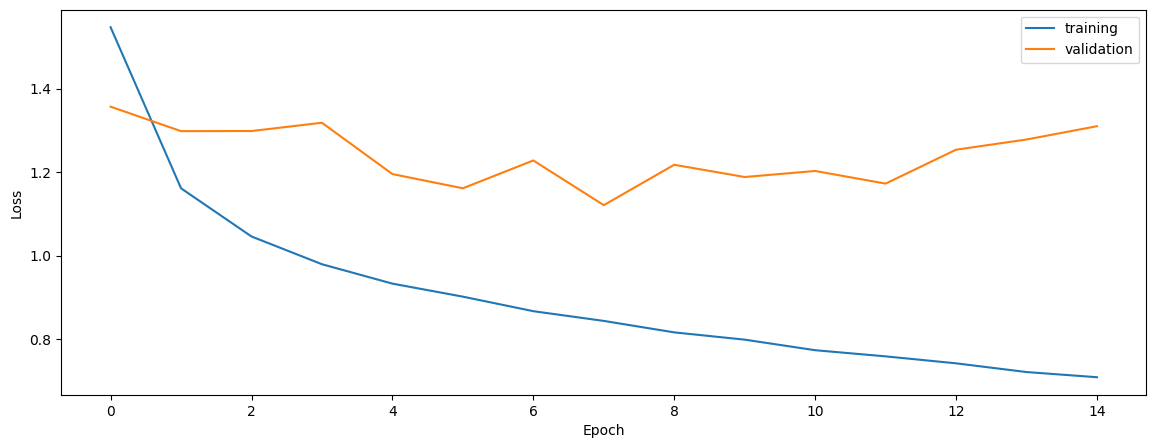

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6827891395603713
0.6025194950519285
0.5971855639076937


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6256693808685446
0.5940880169671262
0.550804708143166


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.644861993002462
0.5990463805808409
0.5847887323943662


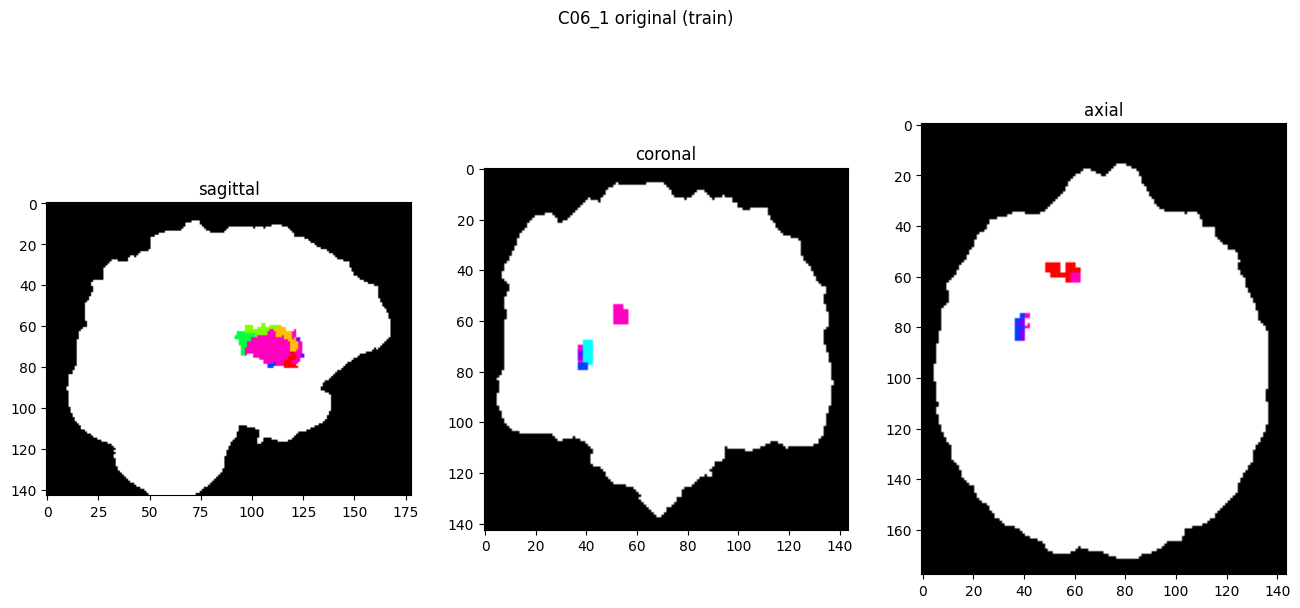

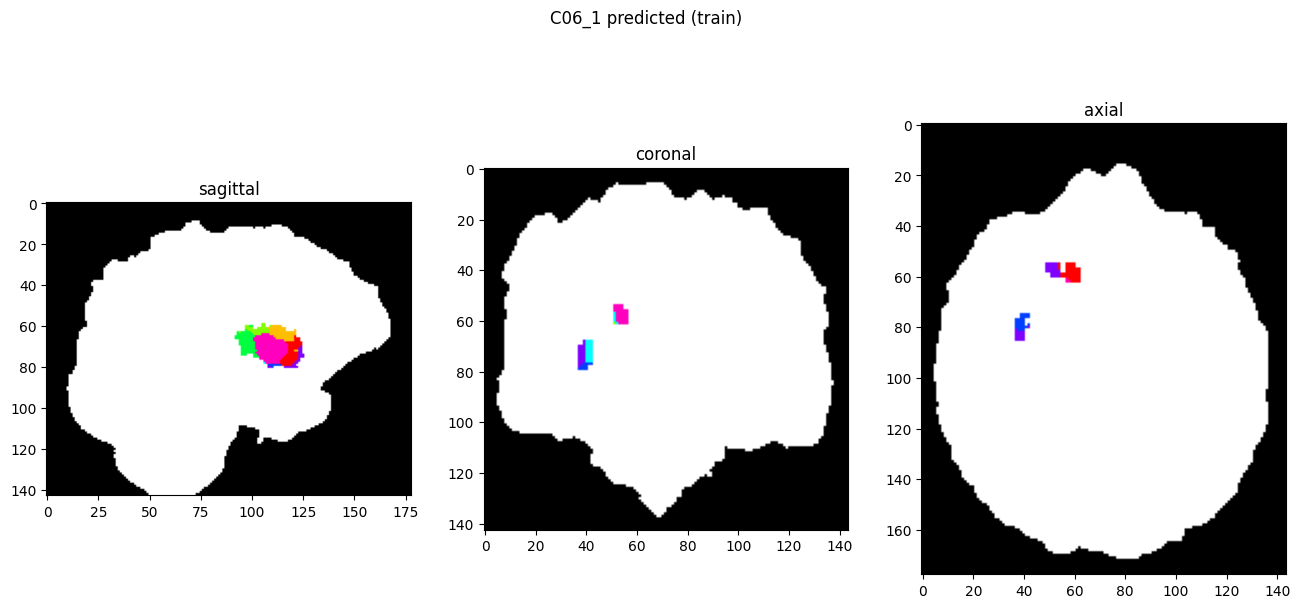

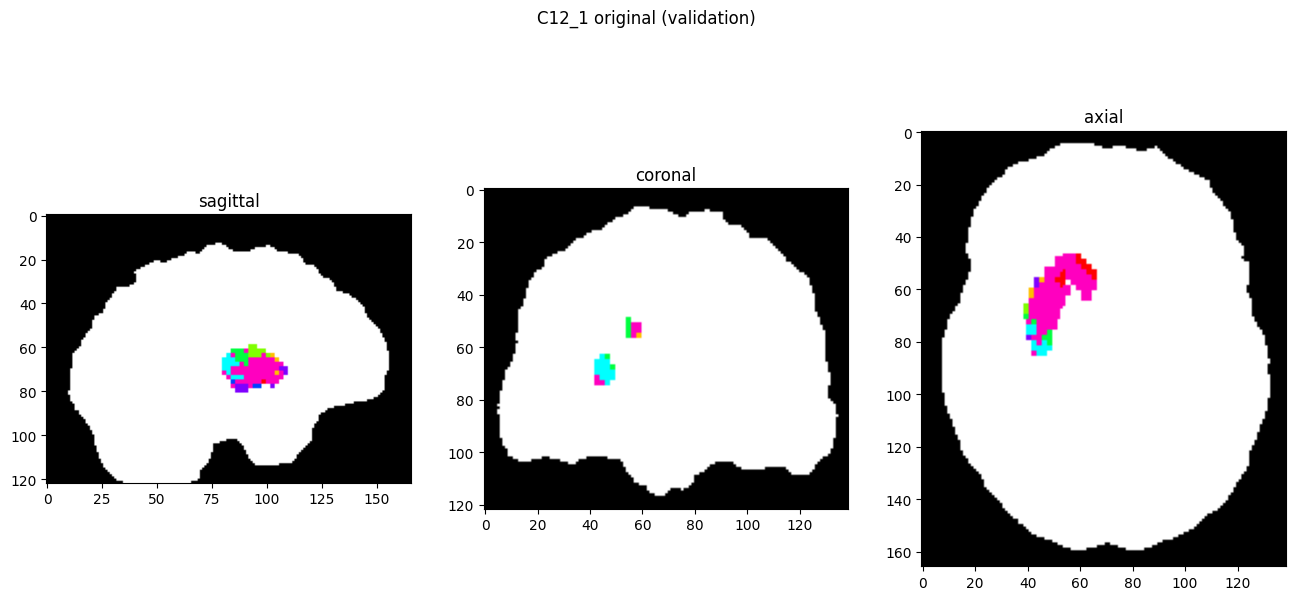

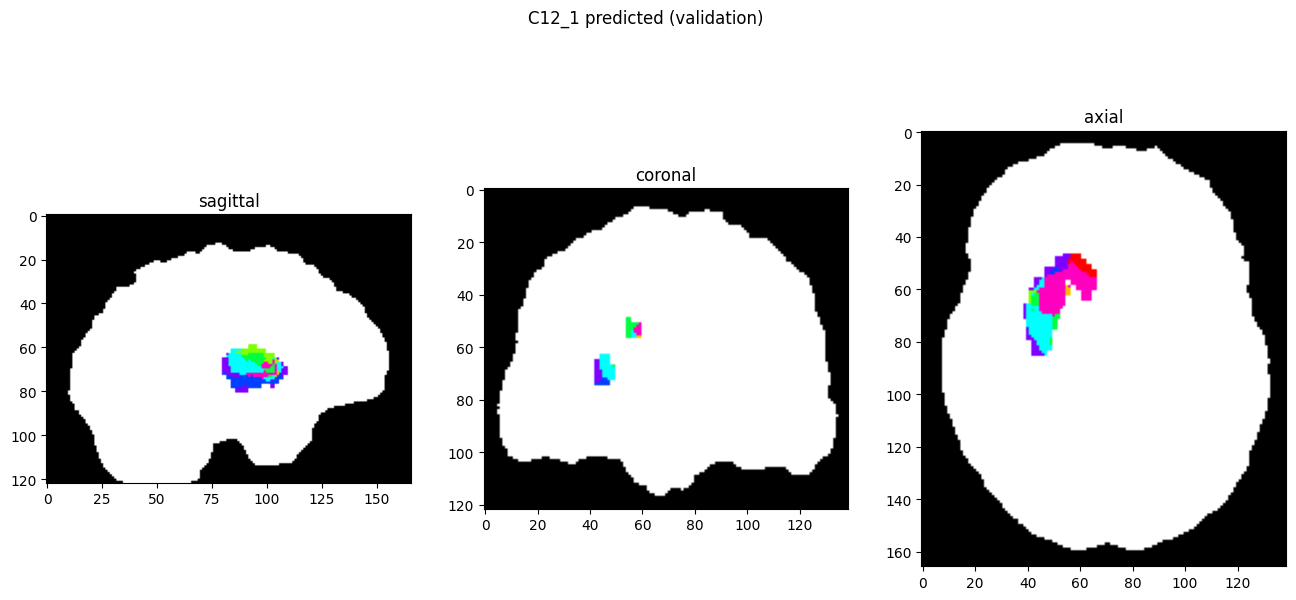

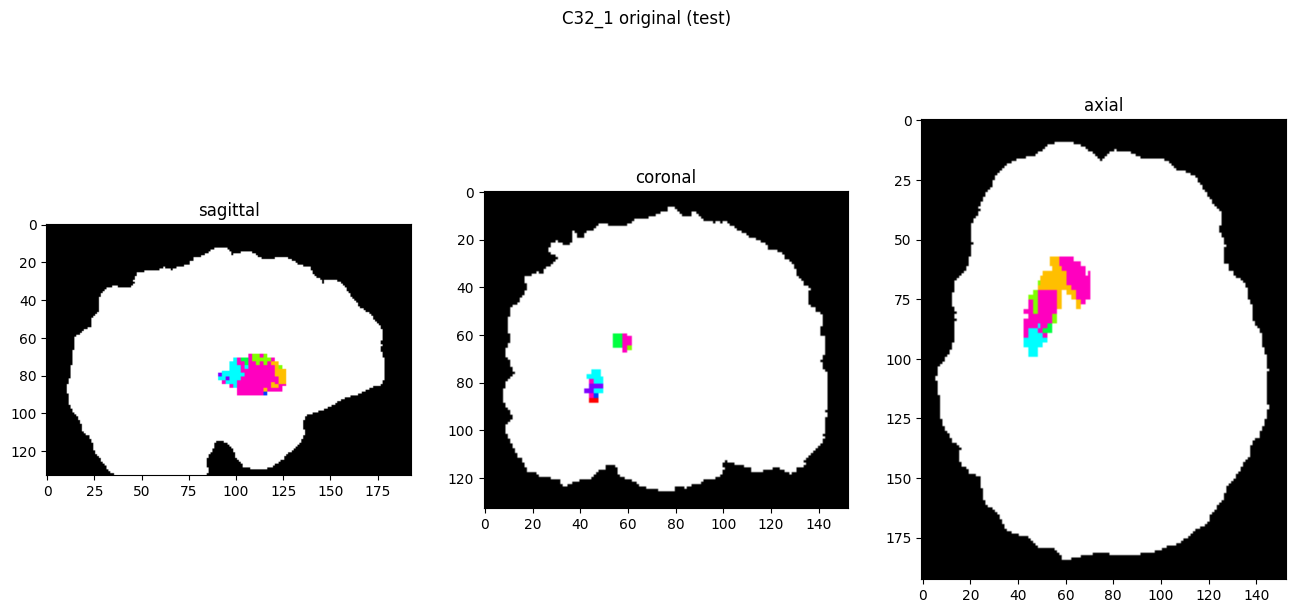

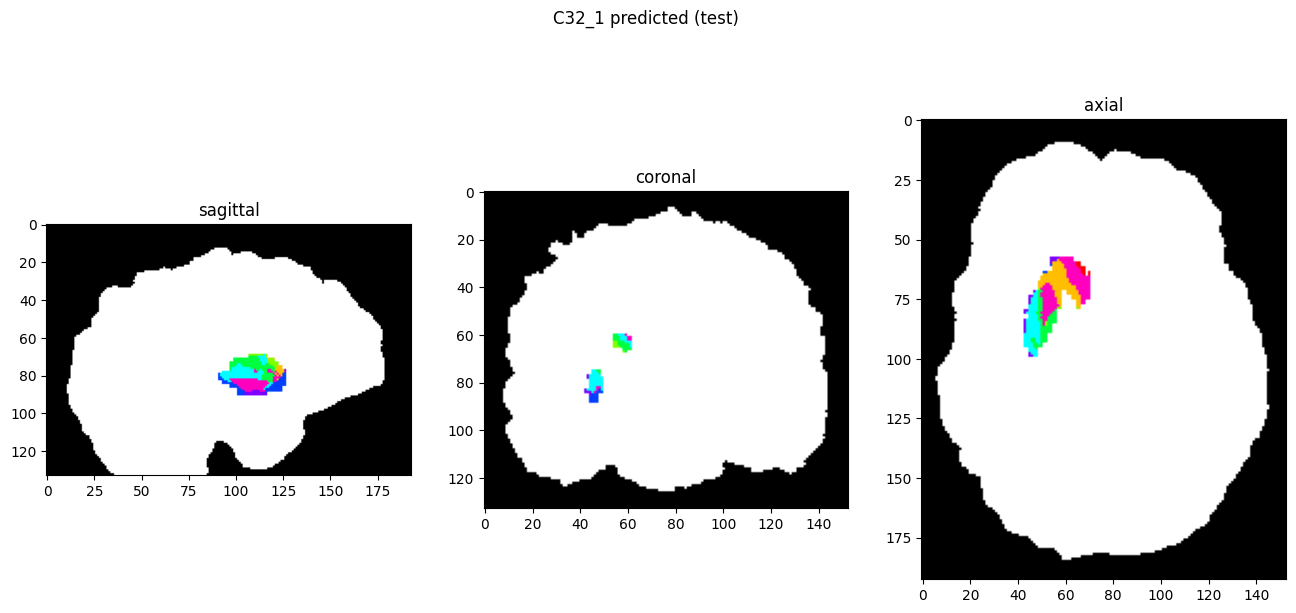

In [10]:
showResults(model, gen, threshold=0)